In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from PIL import Image

# Modeling and Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

/opt/homebrew/anaconda3/envs/Tachyon/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Version skforecast: 0.14.0
Version scikit-learn: 1.6.1
Version pandas: 2.2.3
Version numpy: 2.1.0


In [2]:
df = pd.read_csv("router_metrics_timeseries.csv")

def smape(actual, predicted):
    return np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted))) * 100

In [3]:
# Calculate the correlation matrix
corr_matrix = df.select_dtypes(include=['number']).corr(method='pearson')

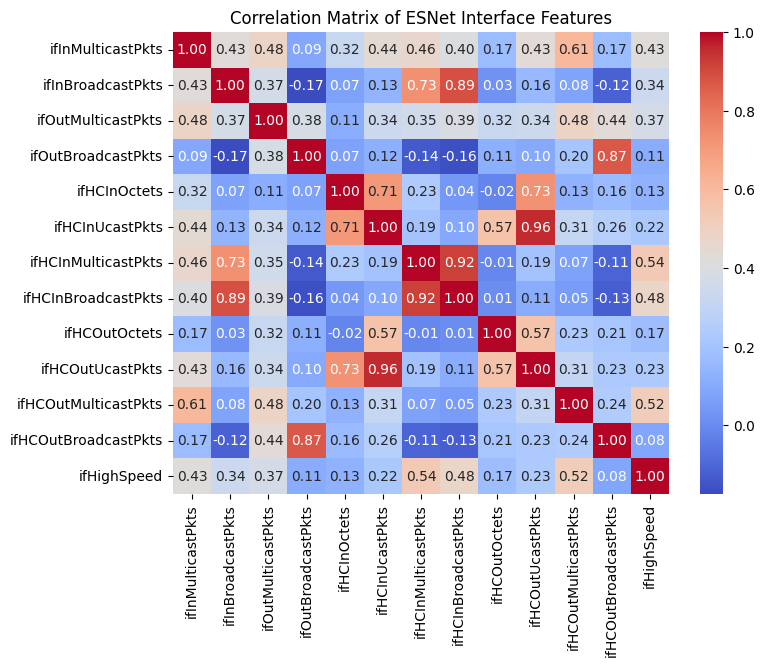

In [4]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of ESNet Interface Features')
plt.show()

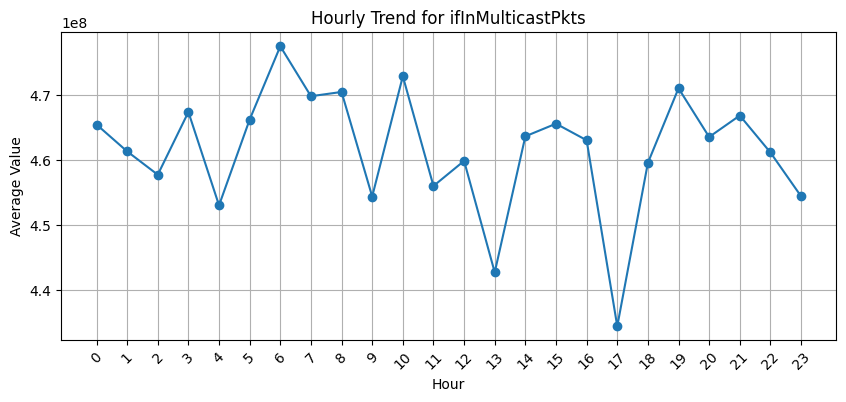

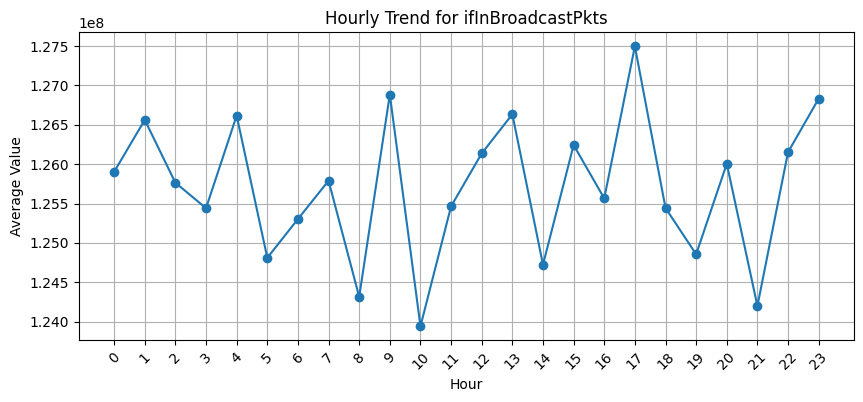

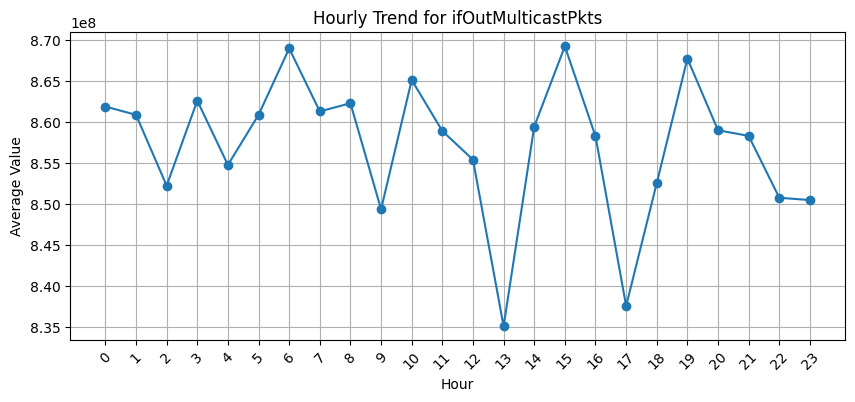

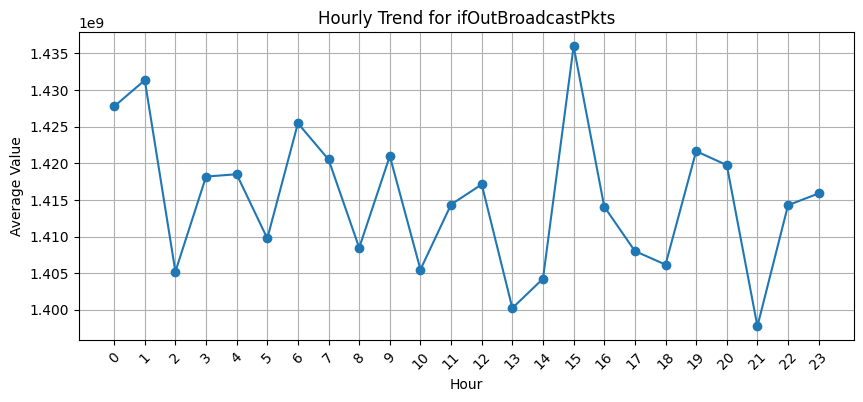

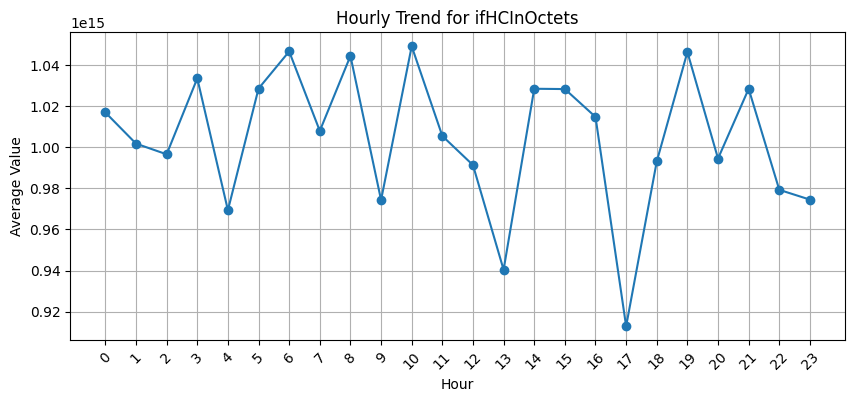

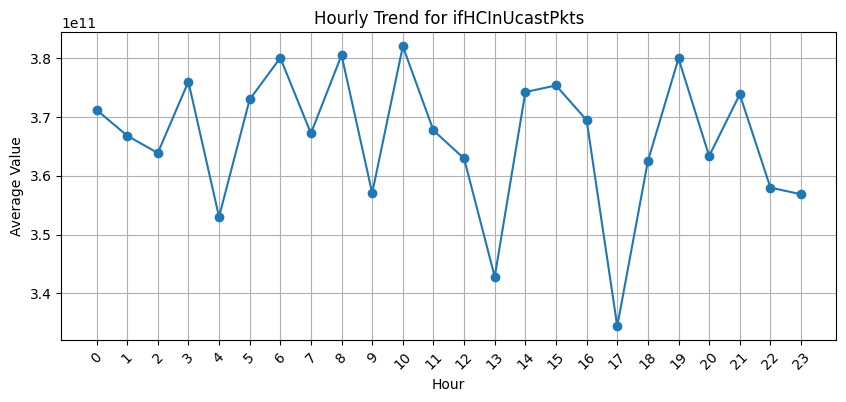

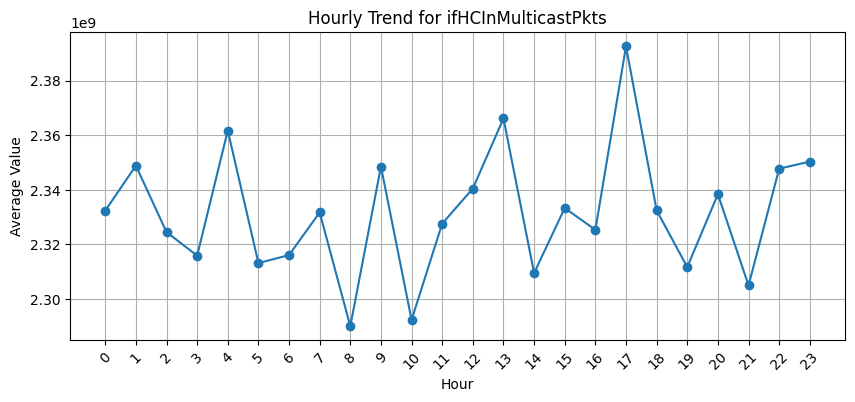

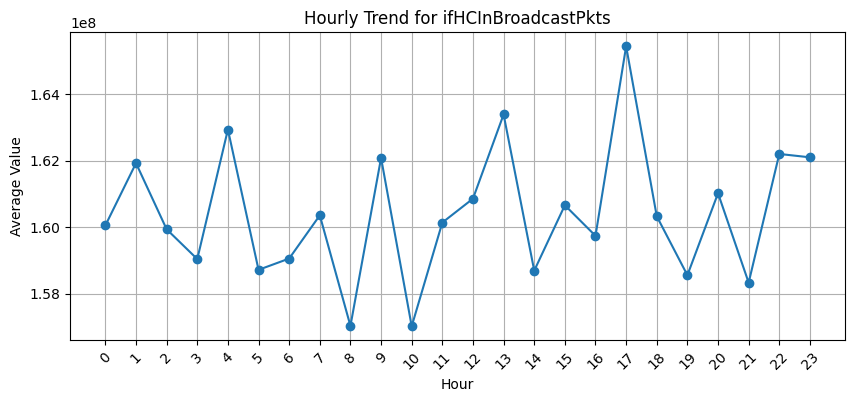

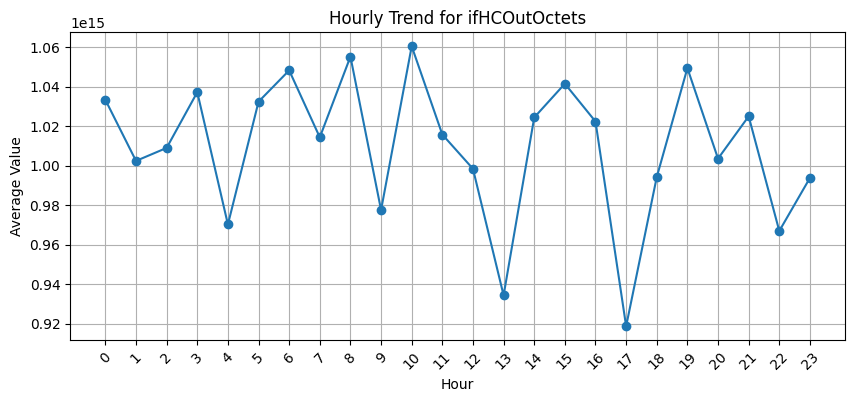

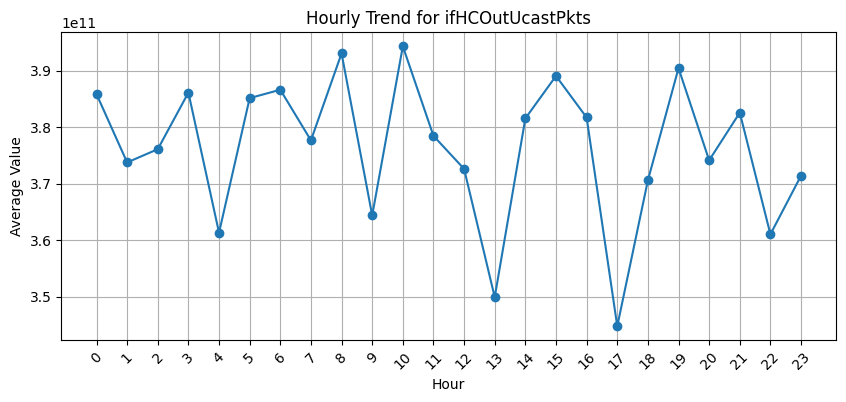

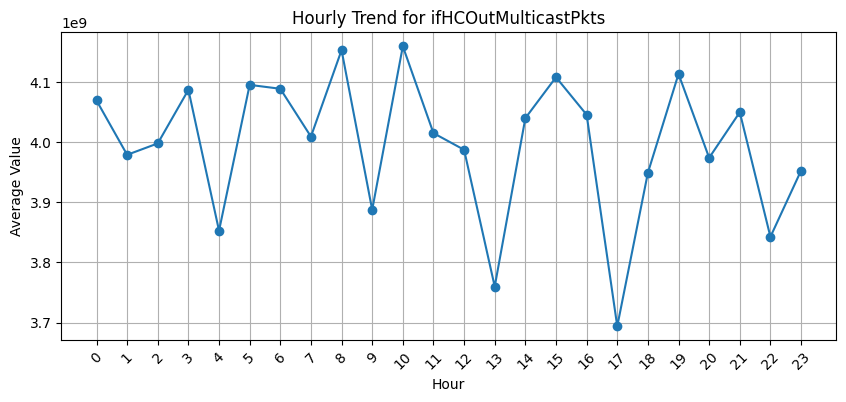

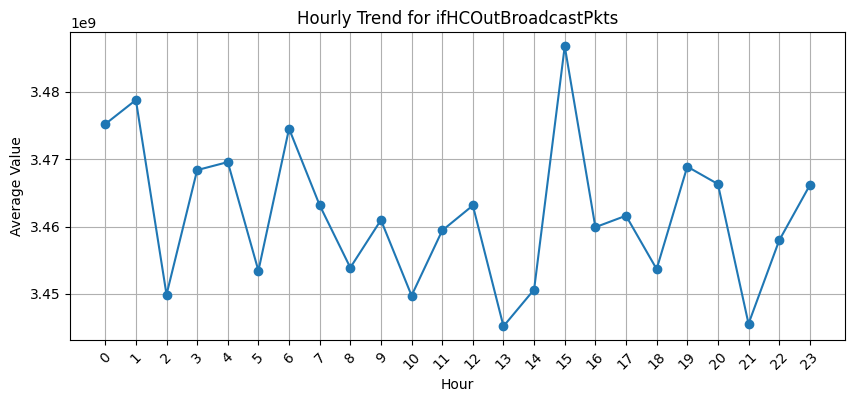

In [5]:
# Extract month and year for aggregation
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df['hour'] = df['timestamp'].dt.hour

# Identify numeric columns for aggregation
numeric_cols = df.select_dtypes(include=['number']).columns

# Aggregate data by month
hourly_trends = df.groupby('hour')[numeric_cols].mean()
# Selected features to analyze
selected_features = [
    'ifInMulticastPkts', 'ifInBroadcastPkts', 'ifOutMulticastPkts', 'ifOutBroadcastPkts',
    'ifHCInOctets', 'ifHCInUcastPkts', 'ifHCInMulticastPkts', 'ifHCInBroadcastPkts',
    'ifHCOutOctets', 'ifHCOutUcastPkts', 'ifHCOutMulticastPkts', 'ifHCOutBroadcastPkts'
]

# Filter only available features in the dataset
available_features = [col for col in selected_features if col in df.columns]

# Generate separate plots for each feature
for column in available_features:
    plt.figure(figsize=(10, 4))
    plt.plot(hourly_trends.index.astype(str), hourly_trends[column], marker='o', linestyle='-')
    plt.title(f'Hourly Trend for {column}')
    plt.xlabel('Hour')
    plt.ylabel('Average Value')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()


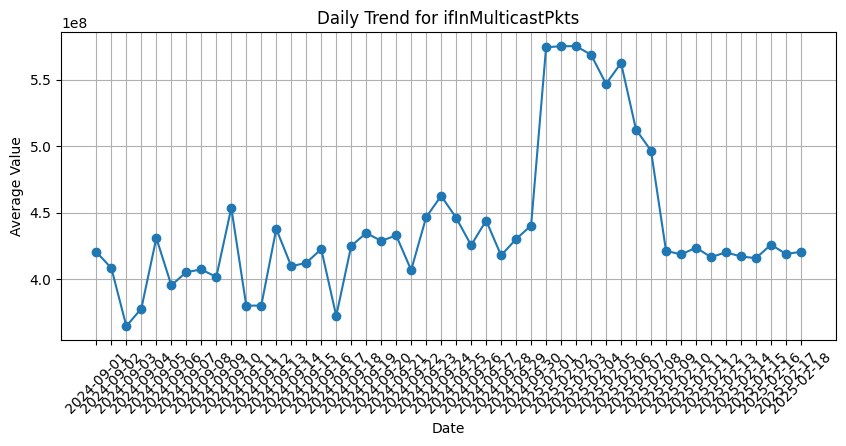

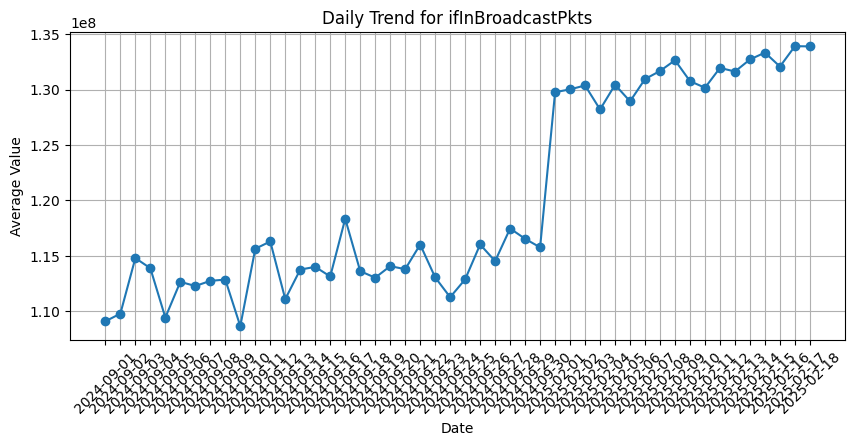

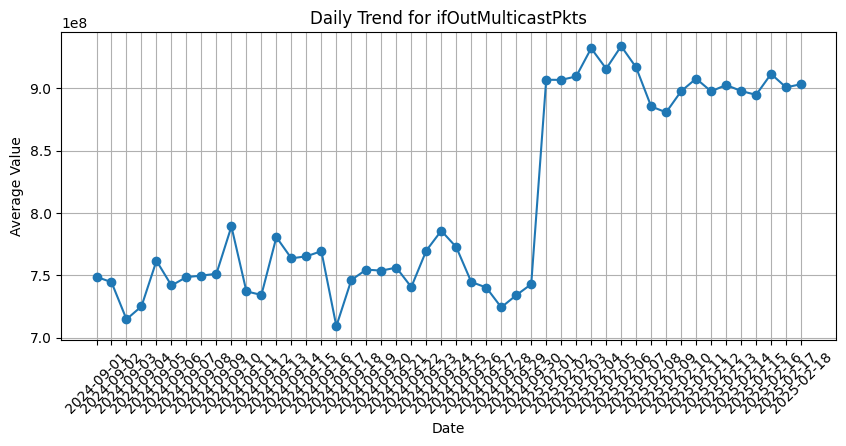

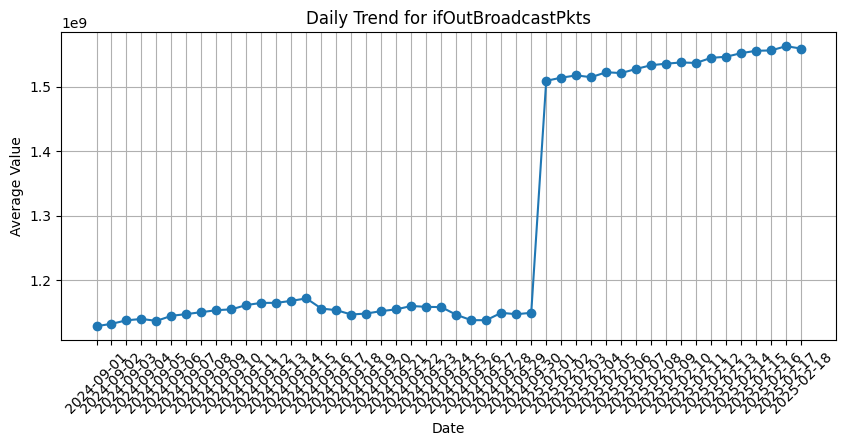

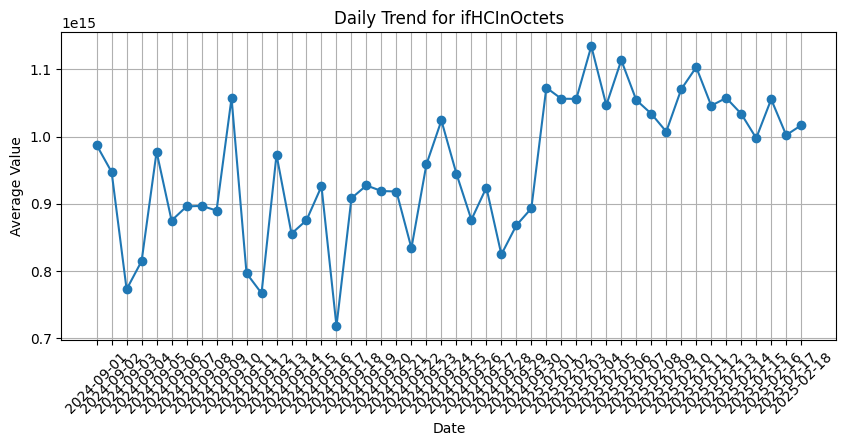

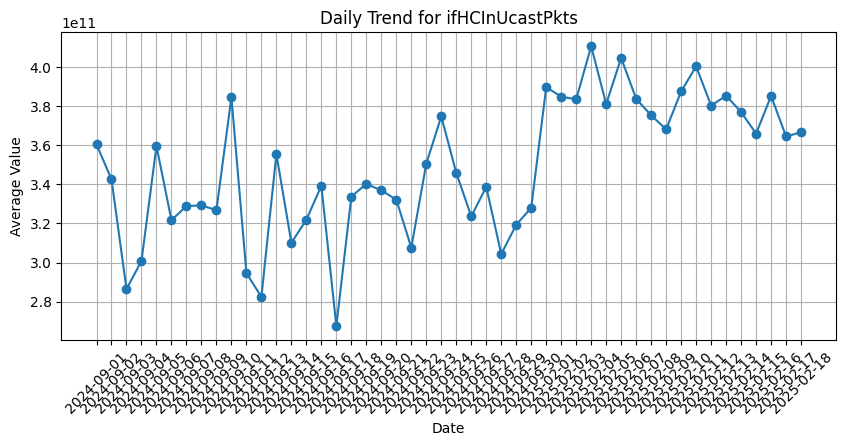

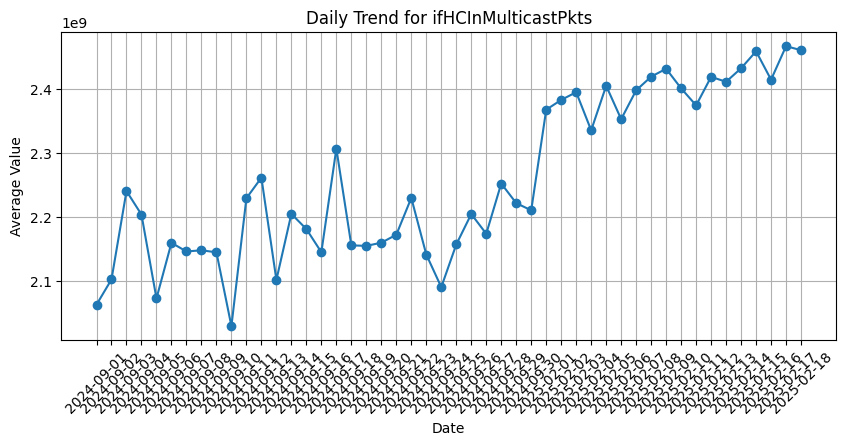

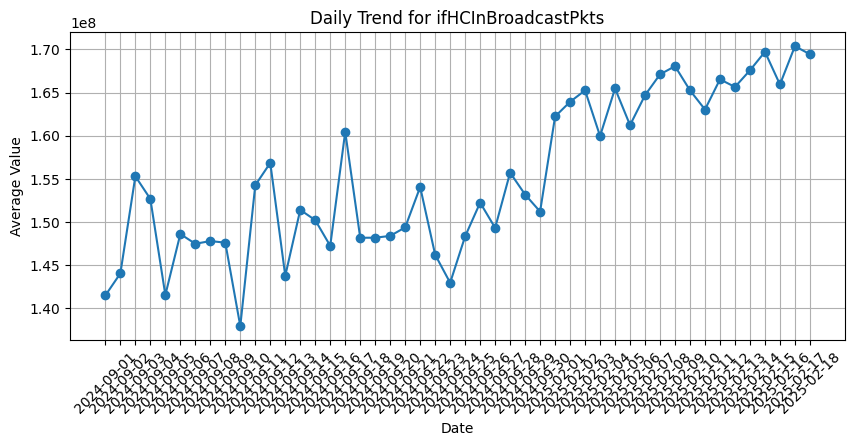

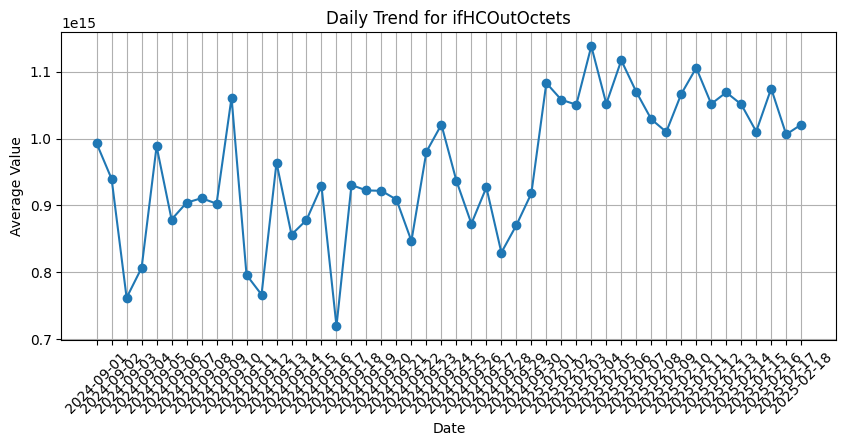

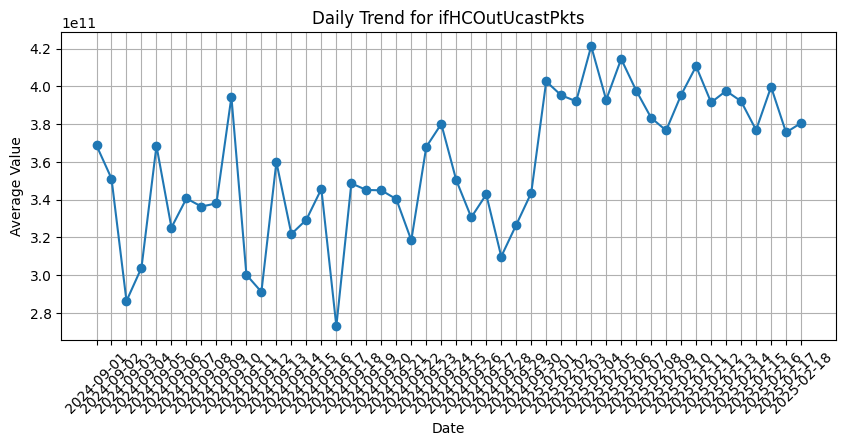

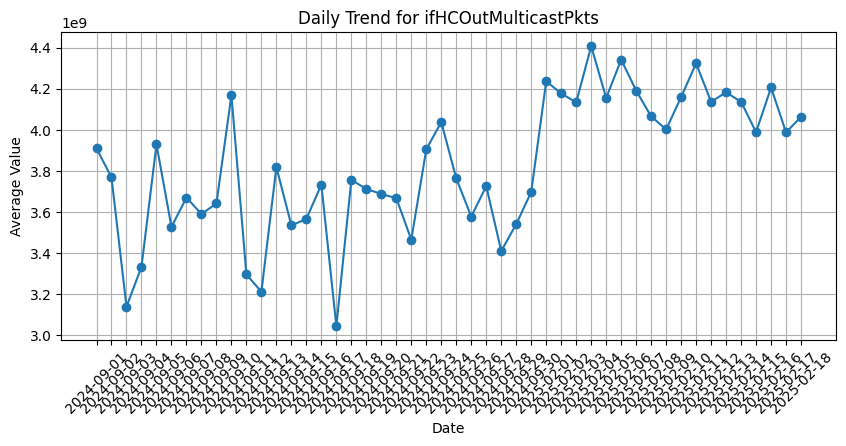

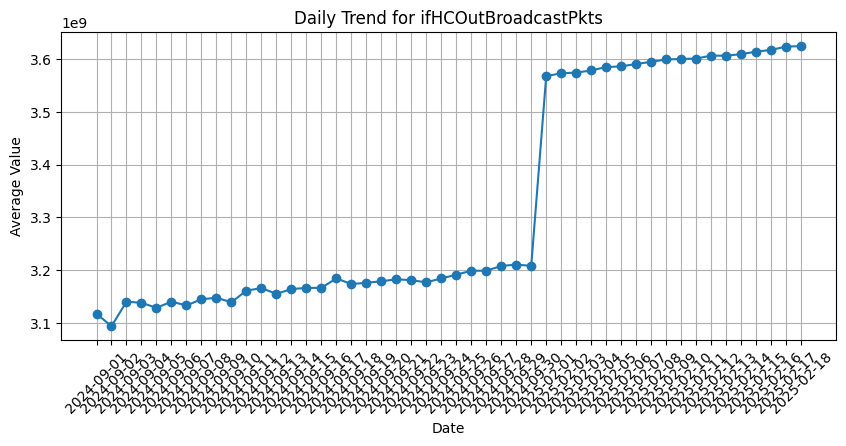

In [6]:
# Extract month and year for aggregation
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df['date'] = df['timestamp'].dt.date

# Identify numeric columns for aggregation
numeric_cols = df.select_dtypes(include=['number']).columns

# Aggregate data by month
daily_trends = df.groupby('date')[numeric_cols].mean()
# Selected features to analyze
selected_features = [
    'ifInMulticastPkts', 'ifInBroadcastPkts', 'ifOutMulticastPkts', 'ifOutBroadcastPkts',
    'ifHCInOctets', 'ifHCInUcastPkts', 'ifHCInMulticastPkts', 'ifHCInBroadcastPkts',
    'ifHCOutOctets', 'ifHCOutUcastPkts', 'ifHCOutMulticastPkts', 'ifHCOutBroadcastPkts'
]

# Filter only available features in the dataset
available_features = [col for col in selected_features if col in df.columns]

# Generate separate plots for each feature
for column in available_features:
    plt.figure(figsize=(10, 4))
    plt.plot(daily_trends.index.astype(str), daily_trends[column], marker='o', linestyle='-')
    plt.title(f'Daily Trend for {column}')
    plt.xlabel('Date')
    plt.ylabel('Average Value')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

In [7]:
df.columns

Index(['router', 'timestamp', 'interface', 'ifInMulticastPkts',
       'ifInBroadcastPkts', 'ifOutMulticastPkts', 'ifOutBroadcastPkts',
       'ifHCInOctets', 'ifHCInUcastPkts', 'ifHCInMulticastPkts',
       'ifHCInBroadcastPkts', 'ifHCOutOctets', 'ifHCOutUcastPkts',
       'ifHCOutMulticastPkts', 'ifHCOutBroadcastPkts',
       'ifLinkUpDownTrapEnable', 'ifHighSpeed', 'ifPromiscuousMode',
       'ifConnectorPresent', 'ifAlias', 'ifCounterDiscontinuityTime',
       'ifTableLastChange', 'ifStackLastChange', 'hour', 'date'],
      dtype='object')

In [8]:
df = pd.read_csv("router_metrics_timeseries.csv")

In [9]:
df = df.rename(columns={'timestamp': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('date')
df = df.groupby(df.index).sum().select_dtypes(include=['number', 'datetime'])
df = df.asfreq('10min', method="ffill")
df = df.sort_index()
df.to_csv("router_metrics_timeseries_patchtst_ffill.csv")

In [10]:
data  = df

In [11]:
# Verify that a temporary index is complete
# ==============================================================================
start_date = data.index.min()
end_date = data.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=data.index.freq)
is_index_complete = (data.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")

Index complete: True


Train dates : 2024-09-01 00:10:07 --- 2025-01-15 19:10:07  (n=19699)
Test dates  : 2025-01-15 19:20:07 --- 2025-02-18 06:20:07  (n=4819)


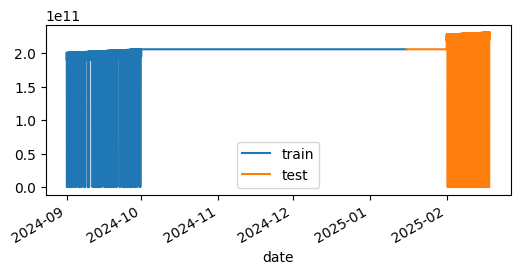

In [12]:
# Split data into train-test
# ==============================================================================
steps = 4819
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['ifHCOutBroadcastPkts'].plot(ax=ax, label='train')
data_test['ifHCOutBroadcastPkts'].plot(ax=ax, label='test')
ax.legend();

In [13]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 1
             )
forecaster.fit(y=data_train['ifHCOutBroadcastPkts'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1] 
Window features: None 
Window size: 1 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2024-09-01 00:10:07'), Timestamp('2025-01-15 19:10:07')] 
Training index type: DatetimeIndex 
Training index frequency: 10min 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-21 10:35:48 
Last fit date: 2025-05-21 10:35:48 
Skforecast version: 0.14.0 
Python version: 3.13.1 
Forecaster id: None

In [14]:
# Predictions
# ==============================================================================
steps = 4819
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2025-01-15 19:20:07    2.061147e+11
2025-01-15 19:30:07    2.061147e+11
2025-01-15 19:40:07    2.061147e+11
2025-01-15 19:50:07    2.061147e+11
2025-01-15 20:00:07    2.061147e+11
Freq: 10min, Name: pred, dtype: float64

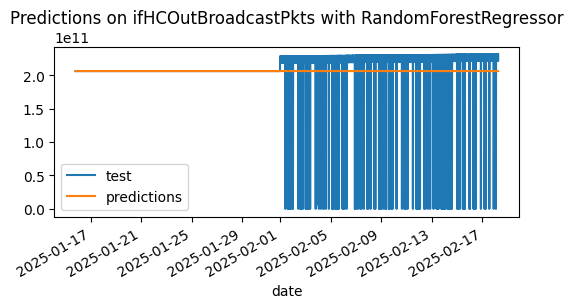

In [15]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_test['ifHCOutBroadcastPkts'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.set_title("Predictions on ifHCOutBroadcastPkts with RandomForestRegressor")
ax.legend();

Shap Summary plot for Random Forest Regressor on ifHCOutBroadcastPkts


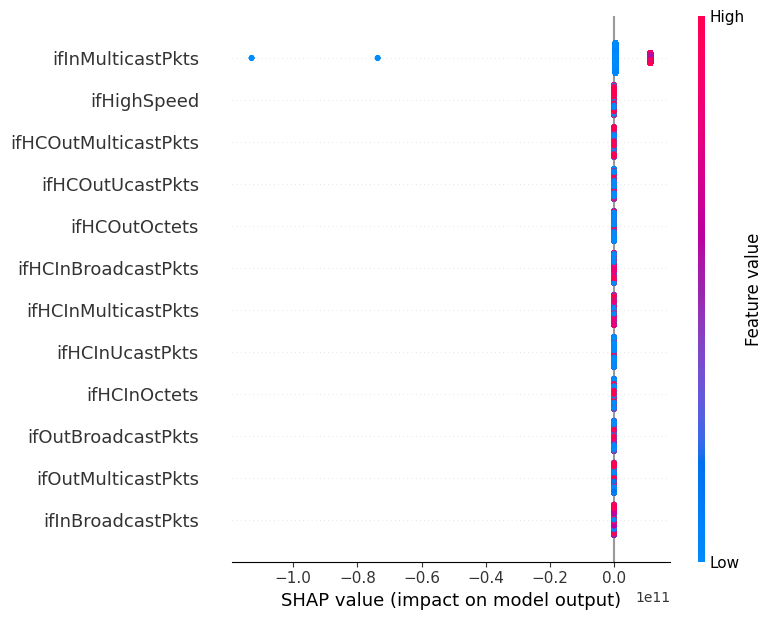

In [16]:
X_train = data_train.copy(deep=True)
X_train.pop("ifHCOutBroadcastPkts")
X_test = data_test.copy(deep=True)
X_test.pop("ifHCOutBroadcastPkts")
print("Shap Summary plot for Random Forest Regressor on ifHCOutBroadcastPkts")
explainer = shap.TreeExplainer(forecaster.regressor, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Shap Summary plot for PatchTST on ifHCOutBroadcastPkts


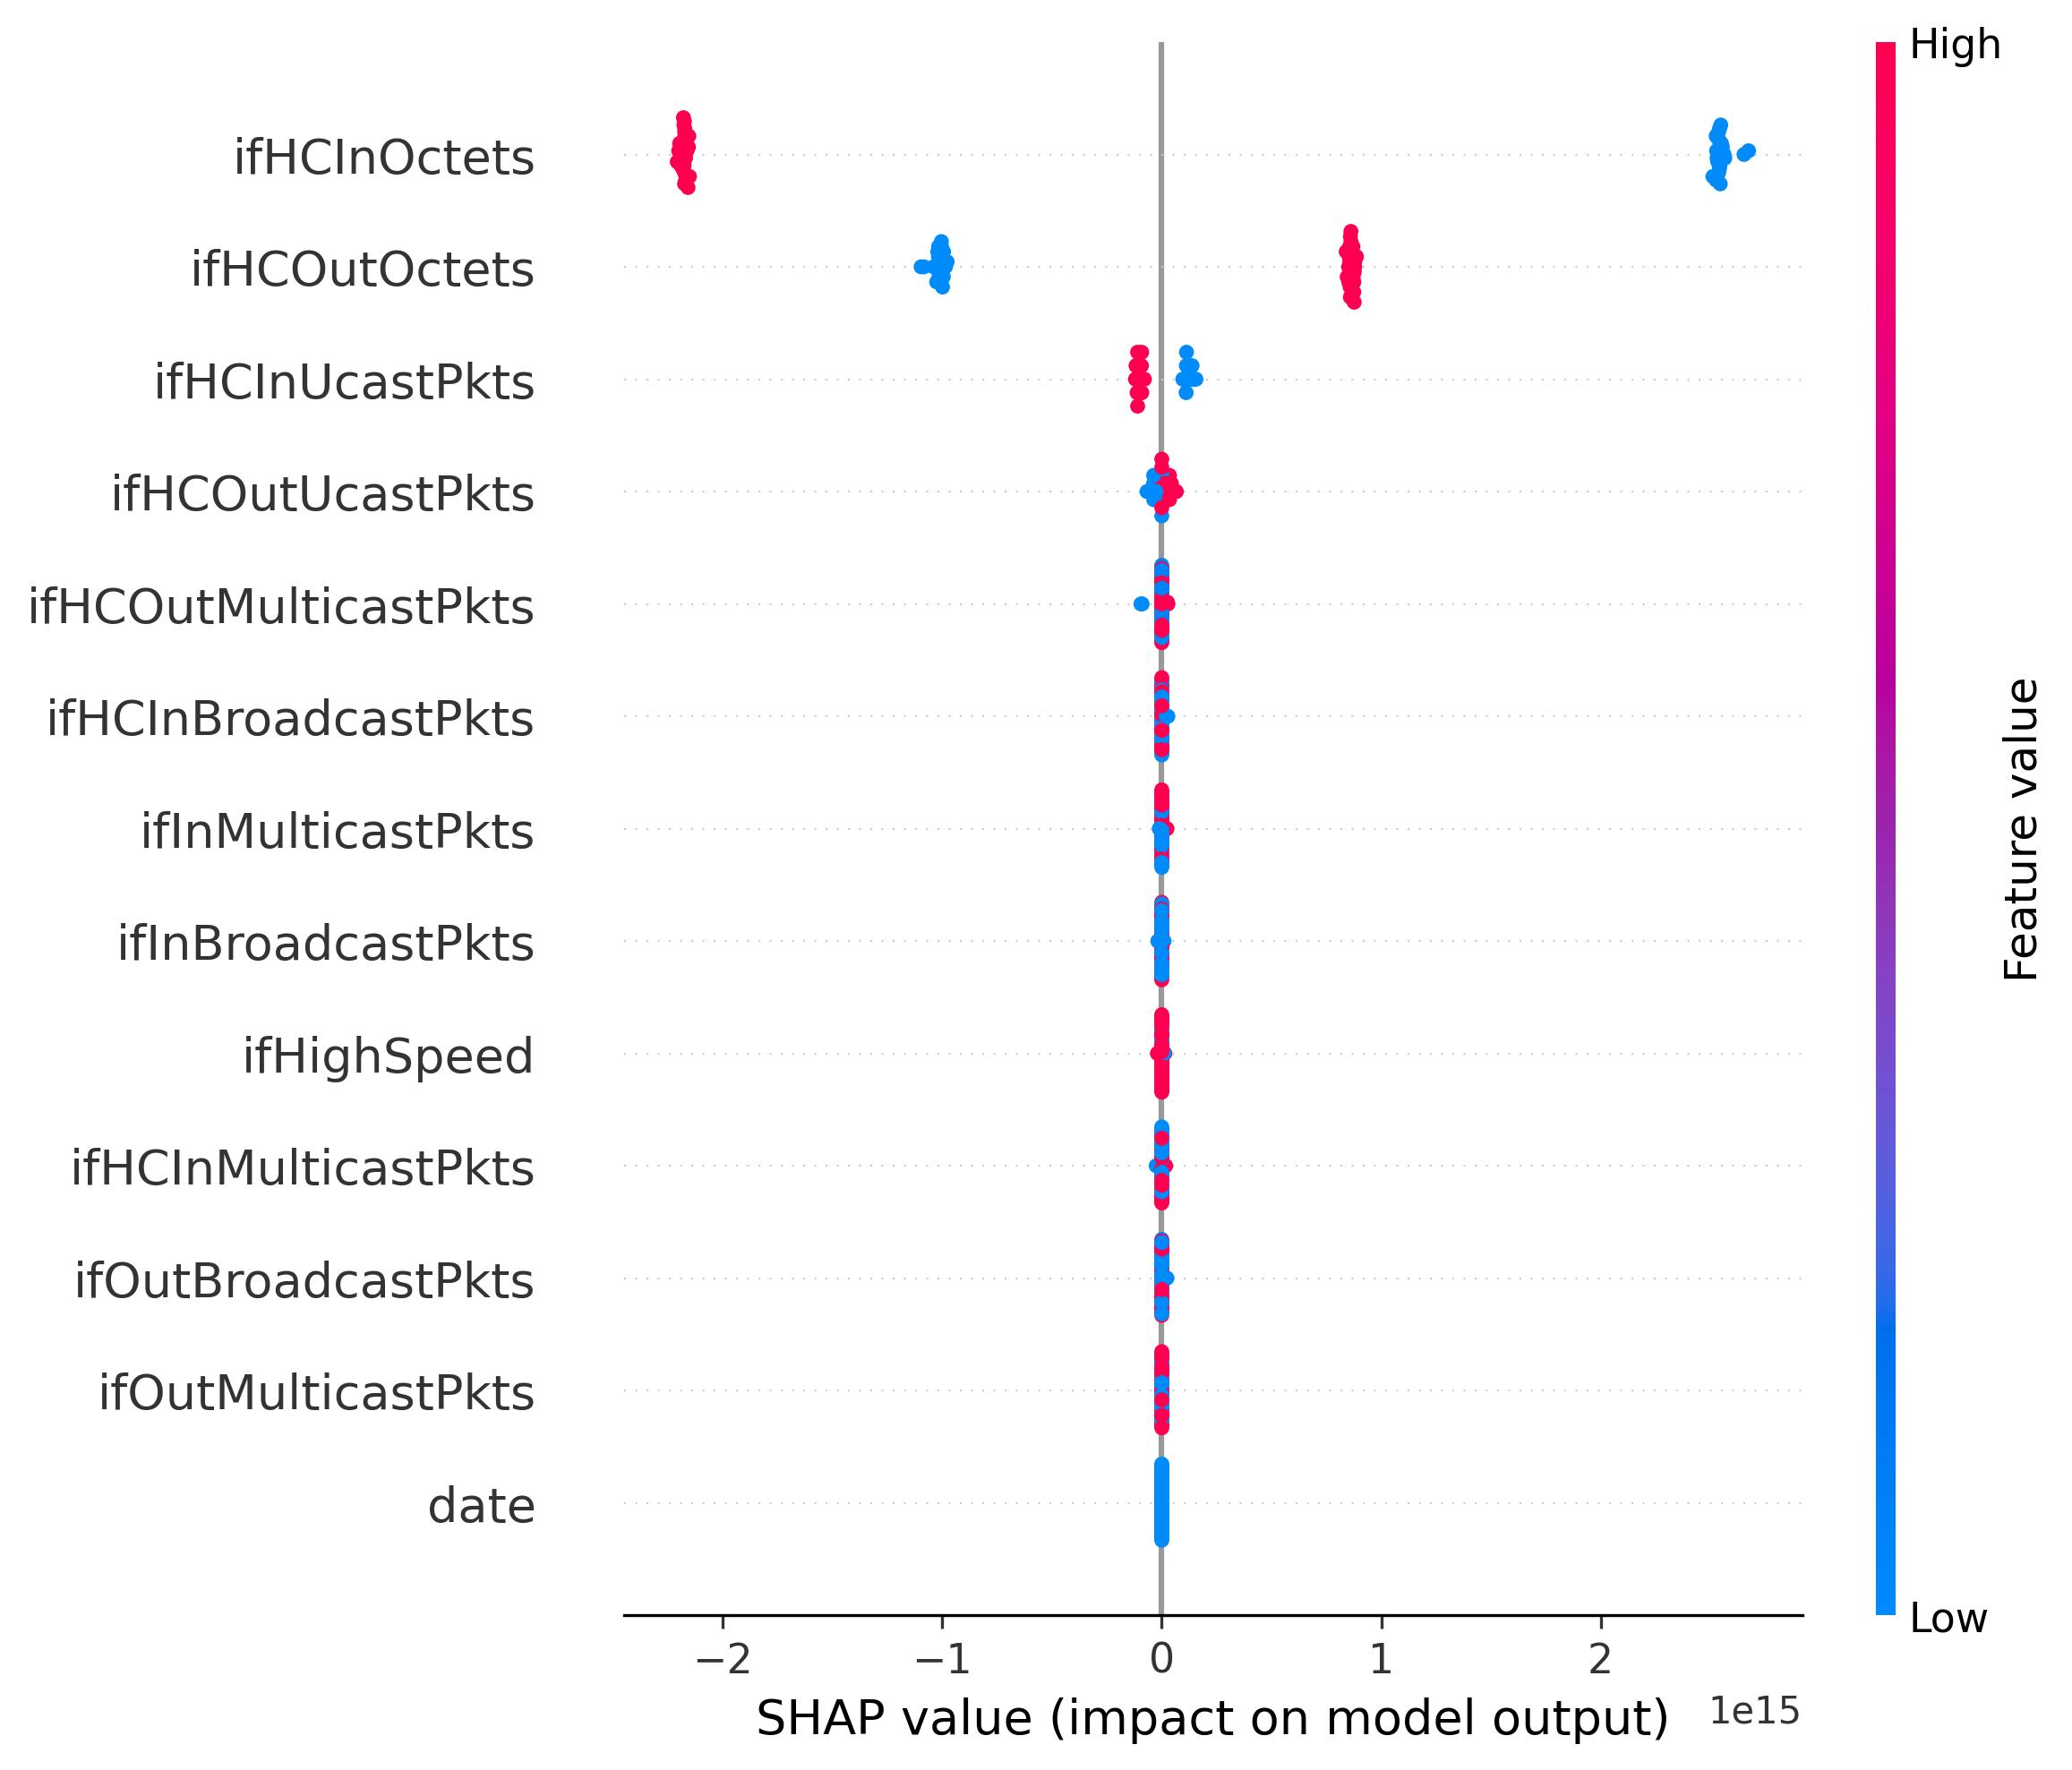

In [17]:
img = Image.open("output_ESNet_broadcast_ffill_10m.jpg")
print("Shap Summary plot for PatchTST on ifHCOutBroadcastPkts")
display(img)

In [18]:
# 1) fit
scaler = StandardScaler().fit(data_test['ifHCOutBroadcastPkts'].to_numpy().reshape(-1, 1))

# 2) transform
y_true_s = scaler.transform(data_test['ifHCOutBroadcastPkts'].to_numpy().reshape(-1, 1)).reshape(data_test['ifHCOutBroadcastPkts'].shape)
y_pred_s = scaler.transform(predictions.to_numpy().reshape(-1, 1)).reshape(predictions.shape)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_true_s,
                y_pred = y_pred_s
            )
error_smape = smape(y_true_s, y_pred_s)
print(f"Test error (MSE): {error_mse}")
print(f"Test error (SMAPE): {error_smape}")

Test error (MSE): 1.0111409638873547
Test error (SMAPE): 103.02613797159188


In [19]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 1
             )
forecaster.fit(y=data_train['ifHCOutOctets'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1] 
Window features: None 
Window size: 1 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2024-09-01 00:10:07'), Timestamp('2025-01-15 19:10:07')] 
Training index type: DatetimeIndex 
Training index frequency: 10min 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-21 10:36:05 
Last fit date: 2025-05-21 10:36:05 
Skforecast version: 0.14.0 
Python version: 3.13.1 
Forecaster id: None

In [20]:
# Predictions
# ==============================================================================
steps = 4819
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2025-01-15 19:20:07    7.008401e+14
2025-01-15 19:30:07    7.008401e+14
2025-01-15 19:40:07    7.008401e+14
2025-01-15 19:50:07    7.008401e+14
2025-01-15 20:00:07    7.008401e+14
Freq: 10min, Name: pred, dtype: float64

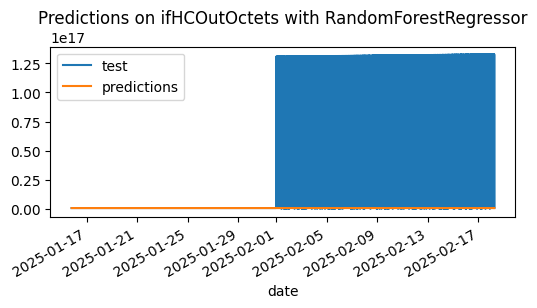

In [21]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_test['ifHCOutOctets'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.set_title("Predictions on ifHCOutOctets with RandomForestRegressor")
ax.legend();

In [22]:
# 1) fit
scaler = StandardScaler().fit(data_test['ifHCOutOctets'].to_numpy().reshape(-1, 1))

# 2) transform
y_true_s = scaler.transform(data_test['ifHCOutOctets'].to_numpy().reshape(-1, 1)).reshape(data_test['ifHCOutOctets'].shape)
y_pred_s = scaler.transform(predictions.to_numpy().reshape(-1, 1)).reshape(predictions.shape)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_true_s,
                y_pred = y_pred_s
            )
error_smape = smape(y_true_s, y_pred_s)
print(f"Test error (MSE): {error_mse}")
print(f"Test error (SMAPE): {error_smape}")

Test error (MSE): 1.3280813862334298
Test error (SMAPE): 49.502127541960725


Shap Summary plot for Random Forest Regressor on ifHCOutOctets


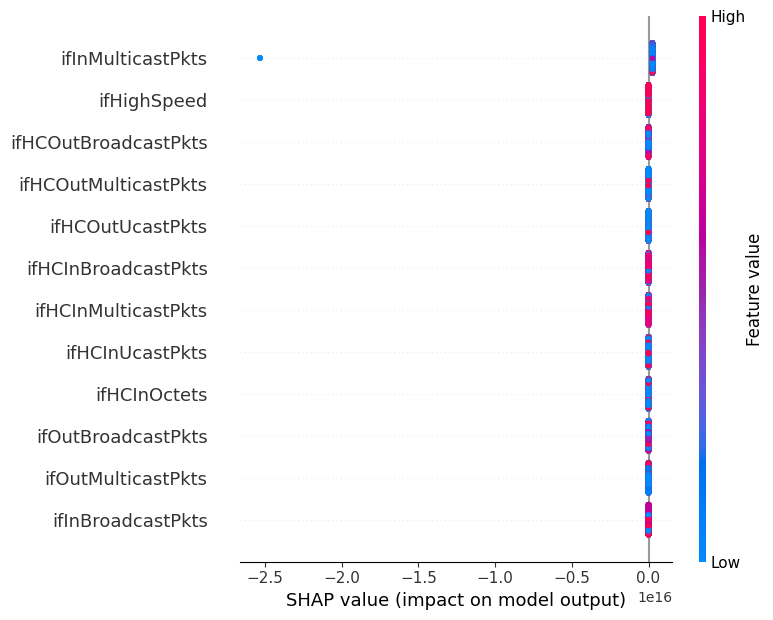

In [23]:
X_train = data_train.copy(deep=True)
X_train.pop("ifHCOutOctets")
X_test = data_test.copy(deep=True)
X_test.pop("ifHCOutOctets")
print("Shap Summary plot for Random Forest Regressor on ifHCOutOctets")
explainer = shap.TreeExplainer(forecaster.regressor, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Shap Summary plot for PatchTST on ifHCOutOctets


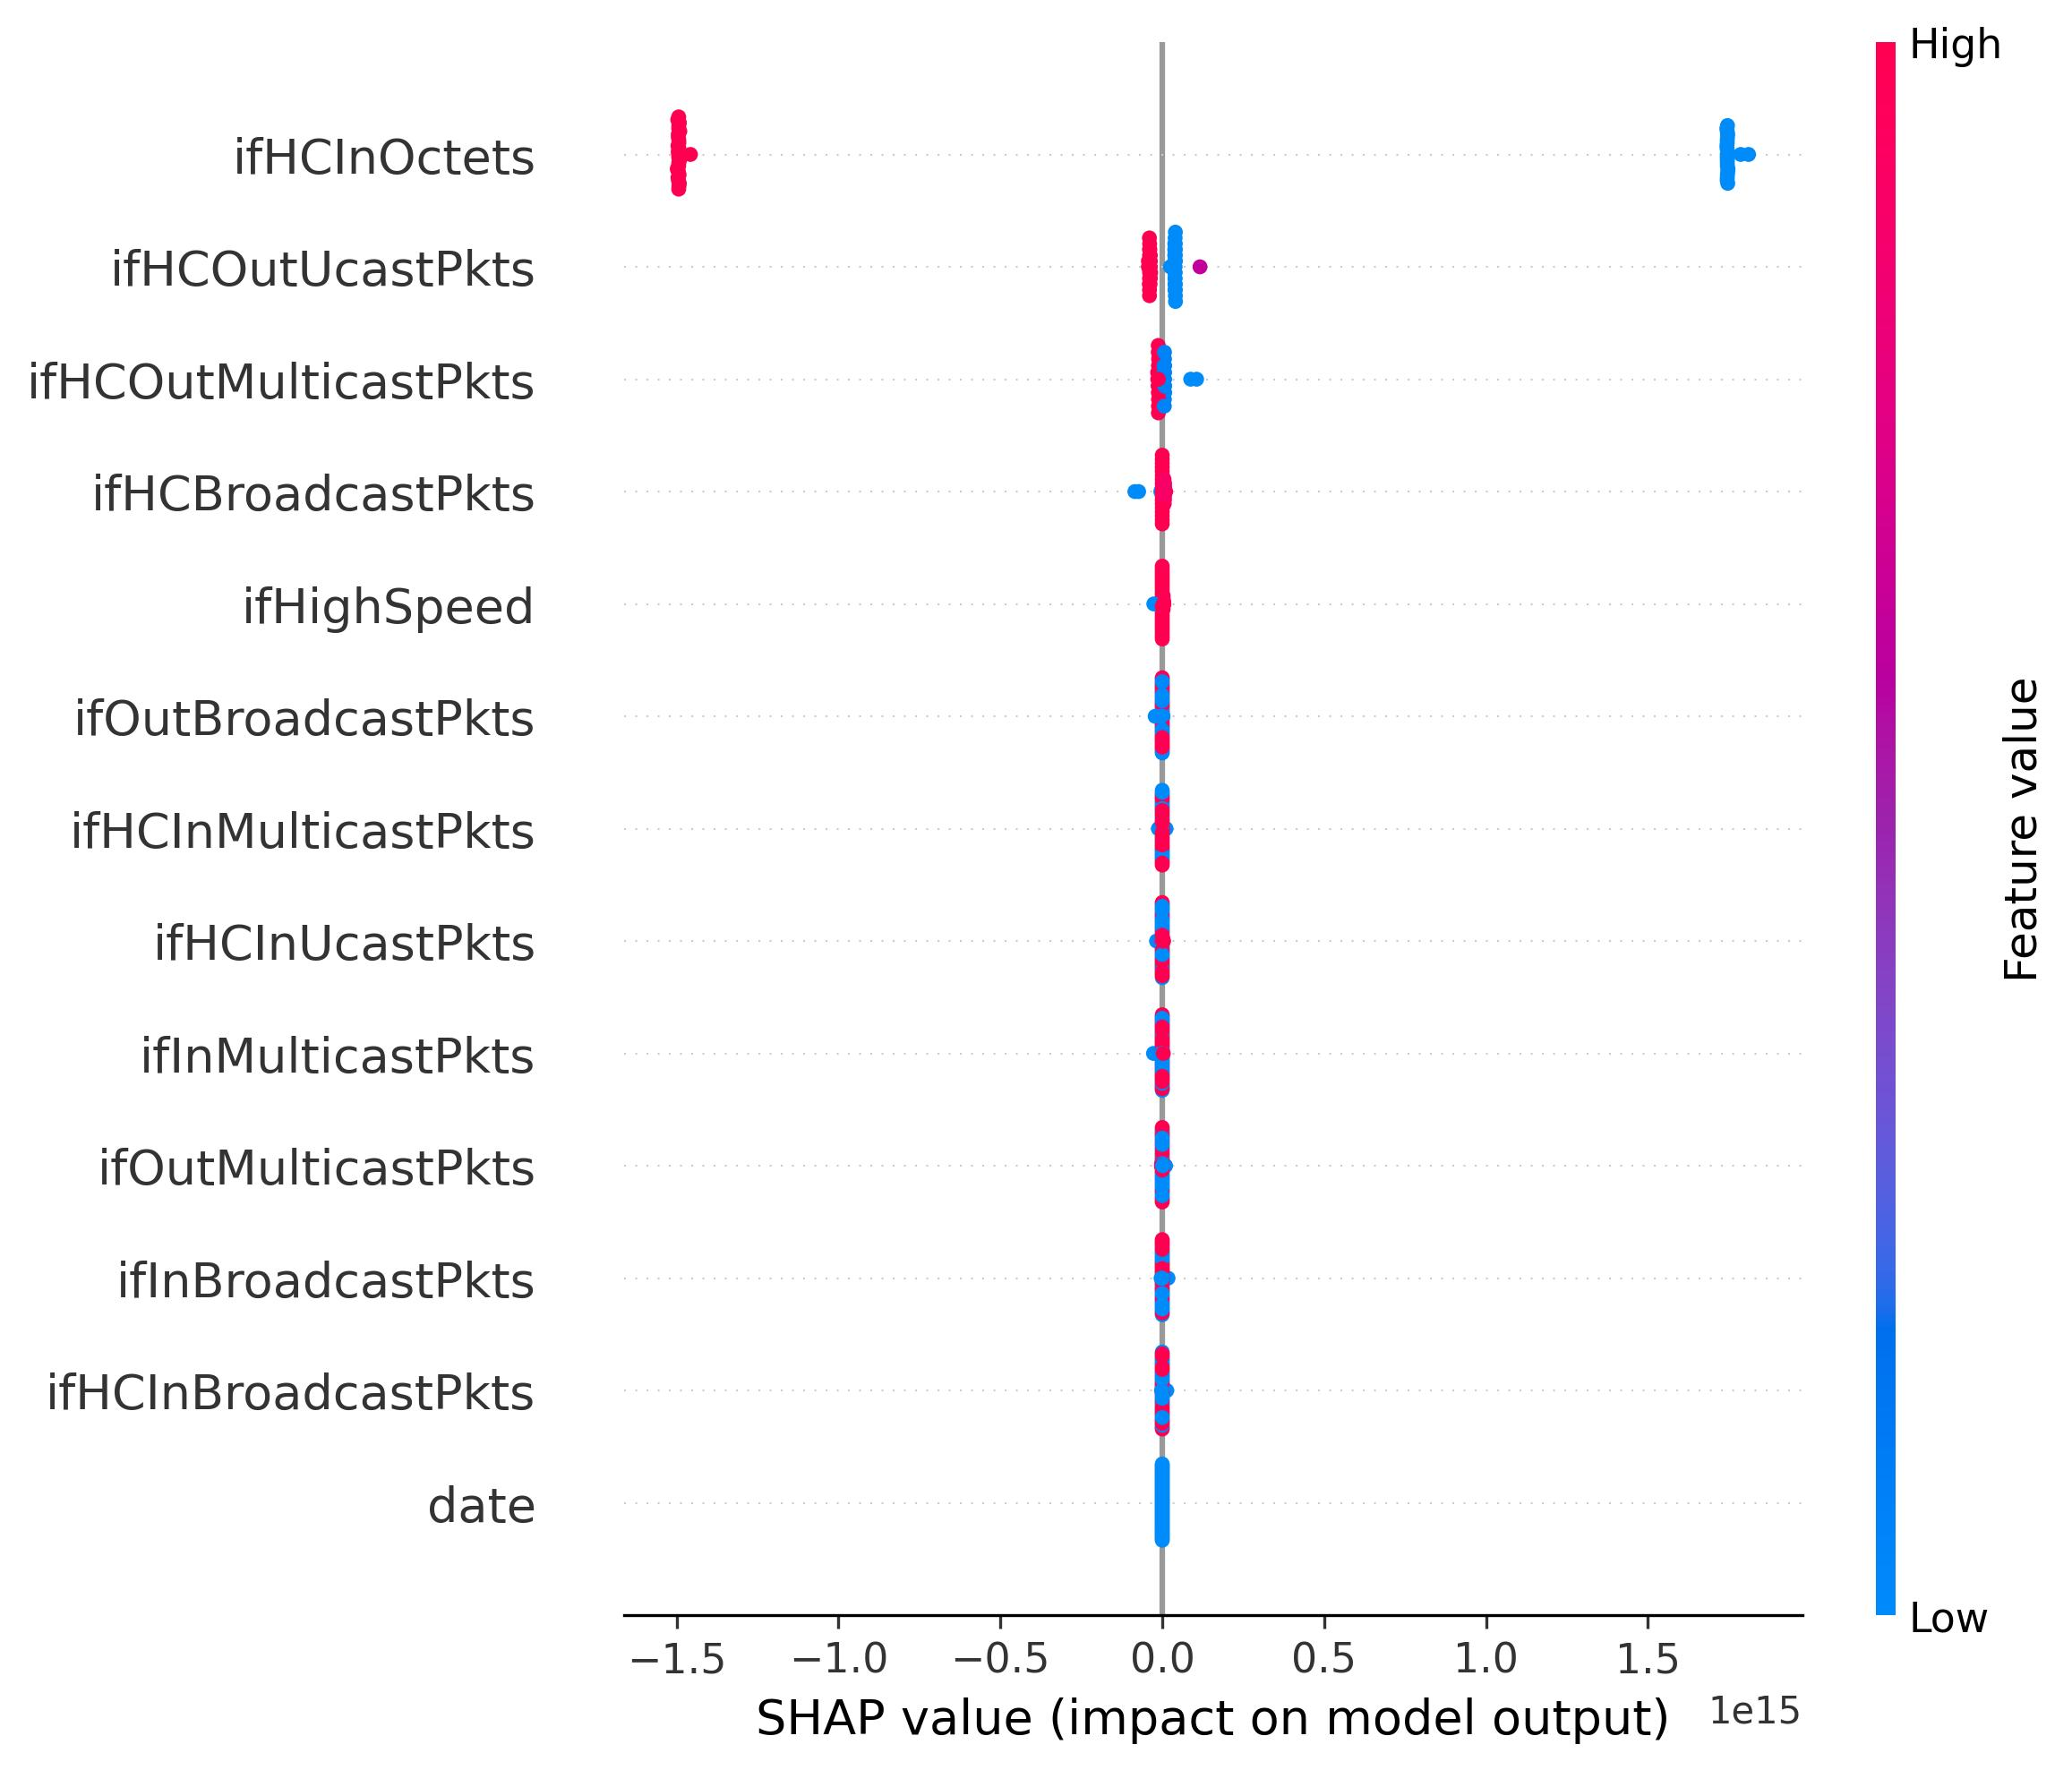

In [24]:
img = Image.open("output_ESNet_octets_ffill_10m.jpg")
print("Shap Summary plot for PatchTST on ifHCOutOctets")
display(img)

In [25]:
df = pd.read_csv("router_metrics_timeseries.csv")

In [26]:
df = df.rename(columns={'timestamp': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('date')
df = df.groupby(df.index).sum().select_dtypes(include=['number', 'datetime'])
df = df.asfreq('10min', method="bfill")
df = df.sort_index()
df.to_csv("router_metrics_timeseries_patchtst_bfill.csv")

Train dates : 2024-09-01 00:10:07 --- 2025-01-15 19:10:07  (n=19699)
Test dates  : 2025-01-15 19:20:07 --- 2025-02-18 06:20:07  (n=4819)


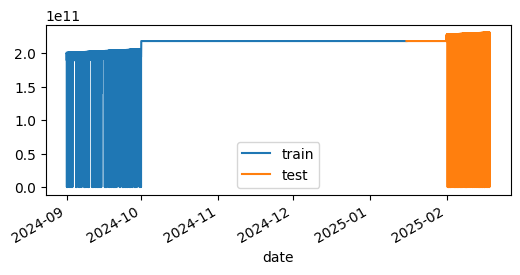

In [27]:
# Split data into train-test
# ==============================================================================
data  = df

steps = 4819
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['ifHCOutBroadcastPkts'].plot(ax=ax, label='train')
data_test['ifHCOutBroadcastPkts'].plot(ax=ax, label='test')
ax.legend();

In [28]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 1
             )
forecaster.fit(y=data_train['ifHCOutBroadcastPkts'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1] 
Window features: None 
Window size: 1 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2024-09-01 00:10:07'), Timestamp('2025-01-15 19:10:07')] 
Training index type: DatetimeIndex 
Training index frequency: 10min 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-21 10:36:20 
Last fit date: 2025-05-21 10:36:20 
Skforecast version: 0.14.0 
Python version: 3.13.1 
Forecaster id: None

In [29]:
# Predictions
# ==============================================================================
steps = 4819
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2025-01-15 19:20:07    2.183992e+11
2025-01-15 19:30:07    2.183992e+11
2025-01-15 19:40:07    2.183992e+11
2025-01-15 19:50:07    2.183992e+11
2025-01-15 20:00:07    2.183992e+11
Freq: 10min, Name: pred, dtype: float64

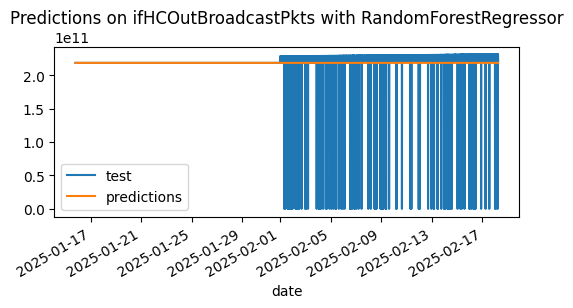

In [30]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_test['ifHCOutBroadcastPkts'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.set_title("Predictions on ifHCOutBroadcastPkts with RandomForestRegressor")
ax.legend();

Shap Summary plot for Random Forest Regressor on ifHCOutBroadcastPkts


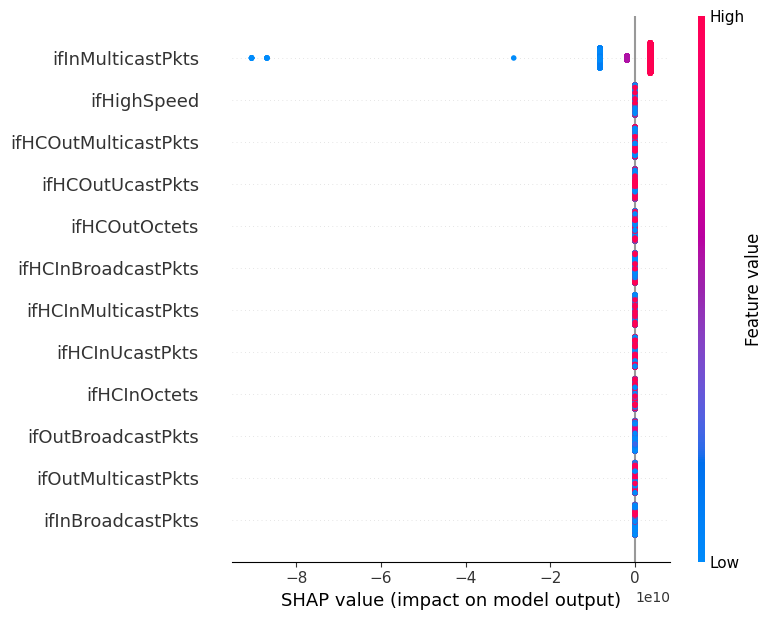

In [31]:
X_train = data_train.copy(deep=True)
X_train.pop("ifHCOutBroadcastPkts")
X_test = data_test.copy(deep=True)
X_test.pop("ifHCOutBroadcastPkts")
print("Shap Summary plot for Random Forest Regressor on ifHCOutBroadcastPkts")
explainer = shap.TreeExplainer(forecaster.regressor, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Shap Summary plot for PatchTST on ifHCOutBroadcastPkts


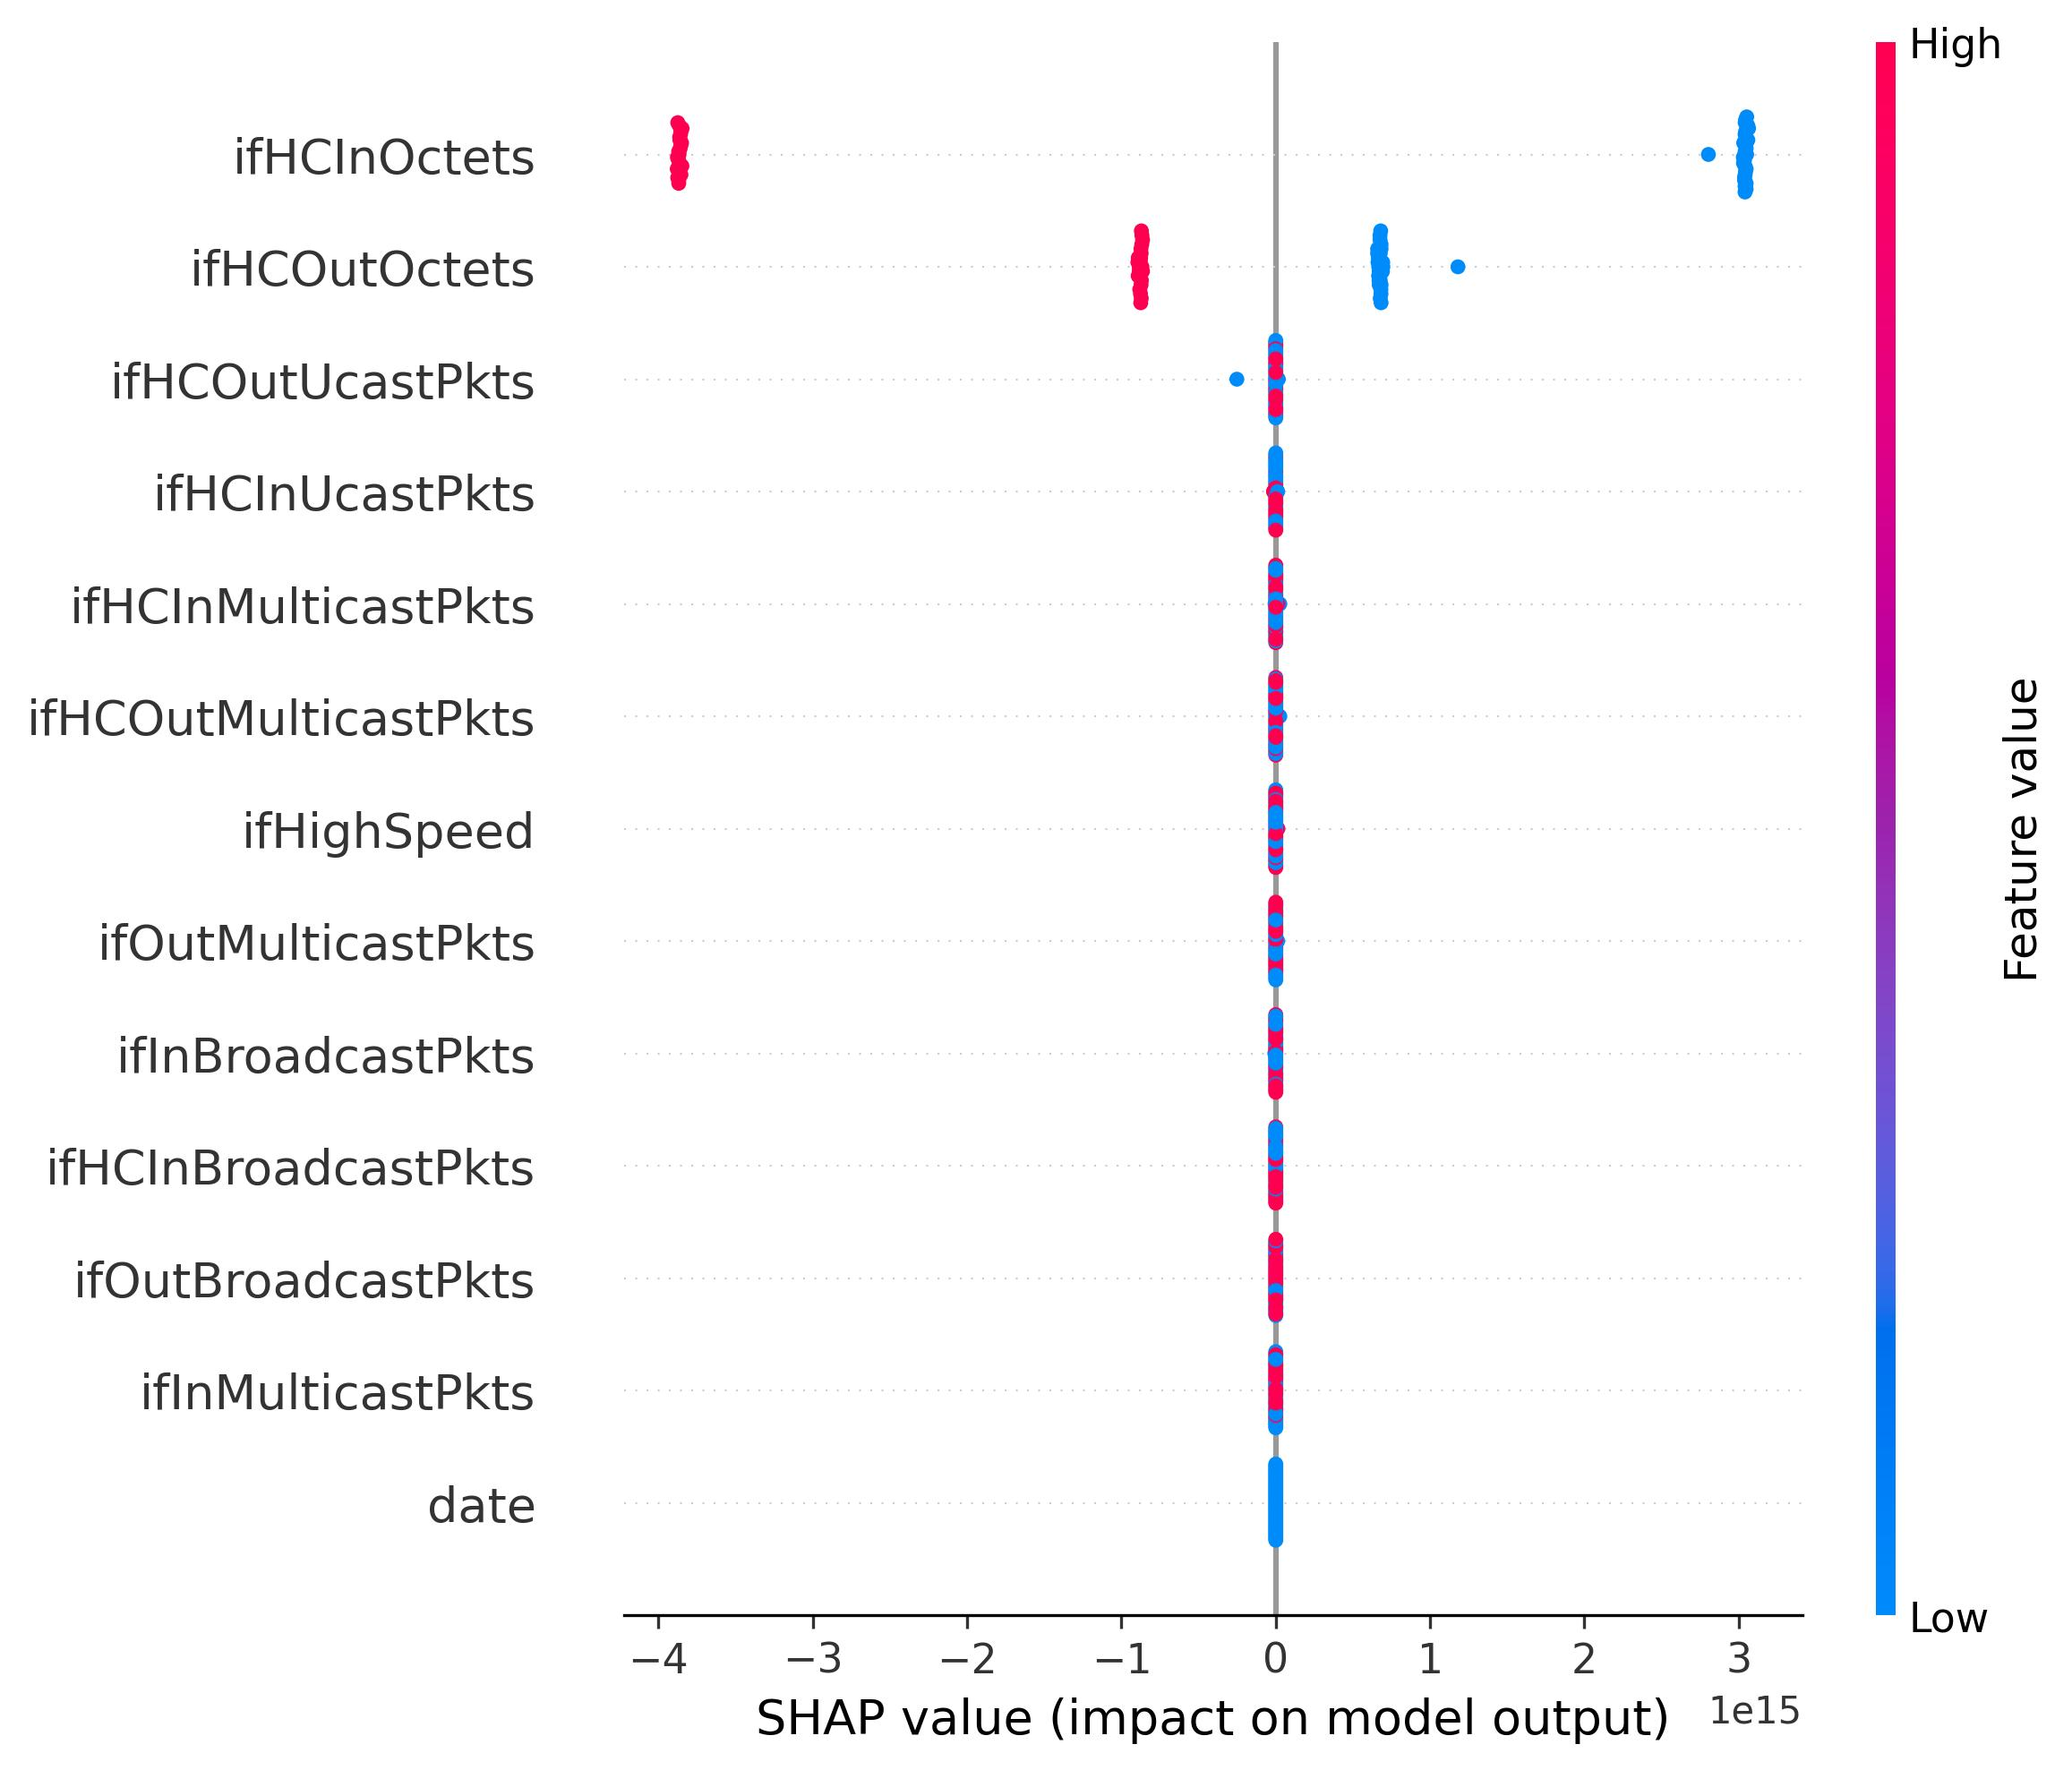

In [32]:
img = Image.open("output_ESNet_broadcast_bfill_10m.jpg")
print("Shap Summary plot for PatchTST on ifHCOutBroadcastPkts")
display(img)

In [33]:
# 1) fit
scaler = StandardScaler().fit(data_test['ifHCOutBroadcastPkts'].to_numpy().reshape(-1, 1))

# 2) transform
y_true_s = scaler.transform(data_test['ifHCOutBroadcastPkts'].to_numpy().reshape(-1, 1)).reshape(data_test['ifHCOutBroadcastPkts'].shape)
y_pred_s = scaler.transform(predictions.to_numpy().reshape(-1, 1)).reshape(predictions.shape)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_true_s,
                y_pred = y_pred_s
            )
error_smape = smape(y_true_s, y_pred_s)
print(f"Test error (MSE): {error_mse}")
print(f"Test error (SMAPE): {error_smape}")

Test error (MSE): 1.0004860265335
Test error (SMAPE): 79.75895471357542


In [34]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 1
             )
forecaster.fit(y=data_train['ifHCOutOctets'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1] 
Window features: None 
Window size: 1 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2024-09-01 00:10:07'), Timestamp('2025-01-15 19:10:07')] 
Training index type: DatetimeIndex 
Training index frequency: 10min 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-21 10:36:34 
Last fit date: 2025-05-21 10:36:35 
Skforecast version: 0.14.0 
Python version: 3.13.1 
Forecaster id: None

In [35]:
# Predictions
# ==============================================================================
steps = 4819
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2025-01-15 19:20:07    1.306662e+17
2025-01-15 19:30:07    1.306662e+17
2025-01-15 19:40:07    1.306662e+17
2025-01-15 19:50:07    1.306662e+17
2025-01-15 20:00:07    1.306662e+17
Freq: 10min, Name: pred, dtype: float64

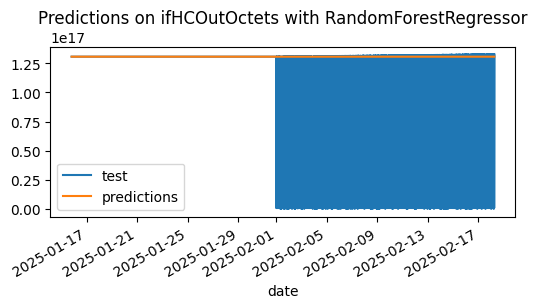

In [36]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_test['ifHCOutOctets'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.set_title("Predictions on ifHCOutOctets with RandomForestRegressor")
ax.legend();

In [37]:
# 1) fit
scaler = StandardScaler().fit(data_test['ifHCOutOctets'].to_numpy().reshape(-1, 1))

# 2) transform
y_true_s = scaler.transform(data_test['ifHCOutOctets'].to_numpy().reshape(-1, 1)).reshape(data_test['ifHCOutOctets'].shape)
y_pred_s = scaler.transform(predictions.to_numpy().reshape(-1, 1)).reshape(predictions.shape)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_true_s,
                y_pred = y_pred_s
            )
error_smape = smape(y_true_s, y_pred_s)
print(f"Test error (MSE): {error_mse}")
print(f"Test error (SMAPE): {error_smape}")

Test error (MSE): 1.584391488381123
Test error (SMAPE): 74.49690710027036


Shap Summary plot for Random Forest Regressor on ifHCOutOctets


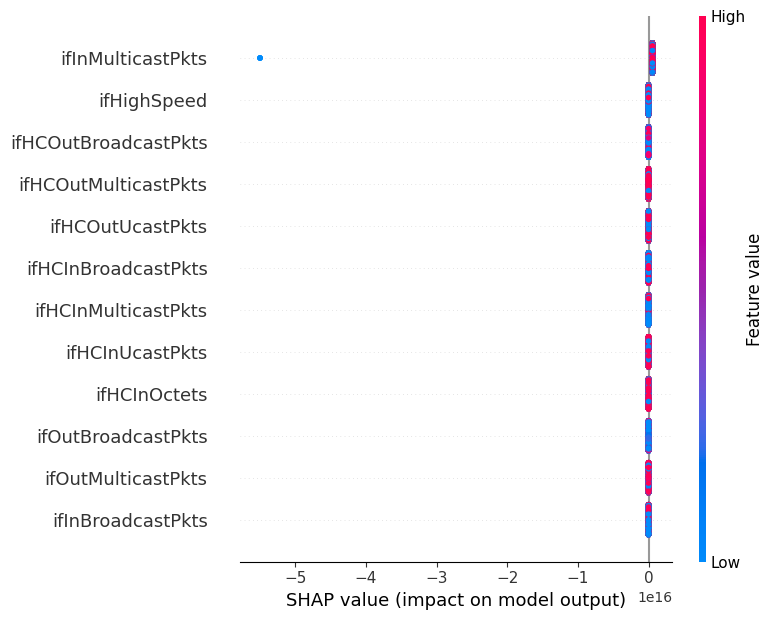

In [38]:
X_train = data_train.copy(deep=True)
X_train.pop("ifHCOutOctets")
X_test = data_test.copy(deep=True)
X_test.pop("ifHCOutOctets")
print("Shap Summary plot for Random Forest Regressor on ifHCOutOctets")
explainer = shap.TreeExplainer(forecaster.regressor, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Shap Summary plot for PatchTST on ifHCOutOctets


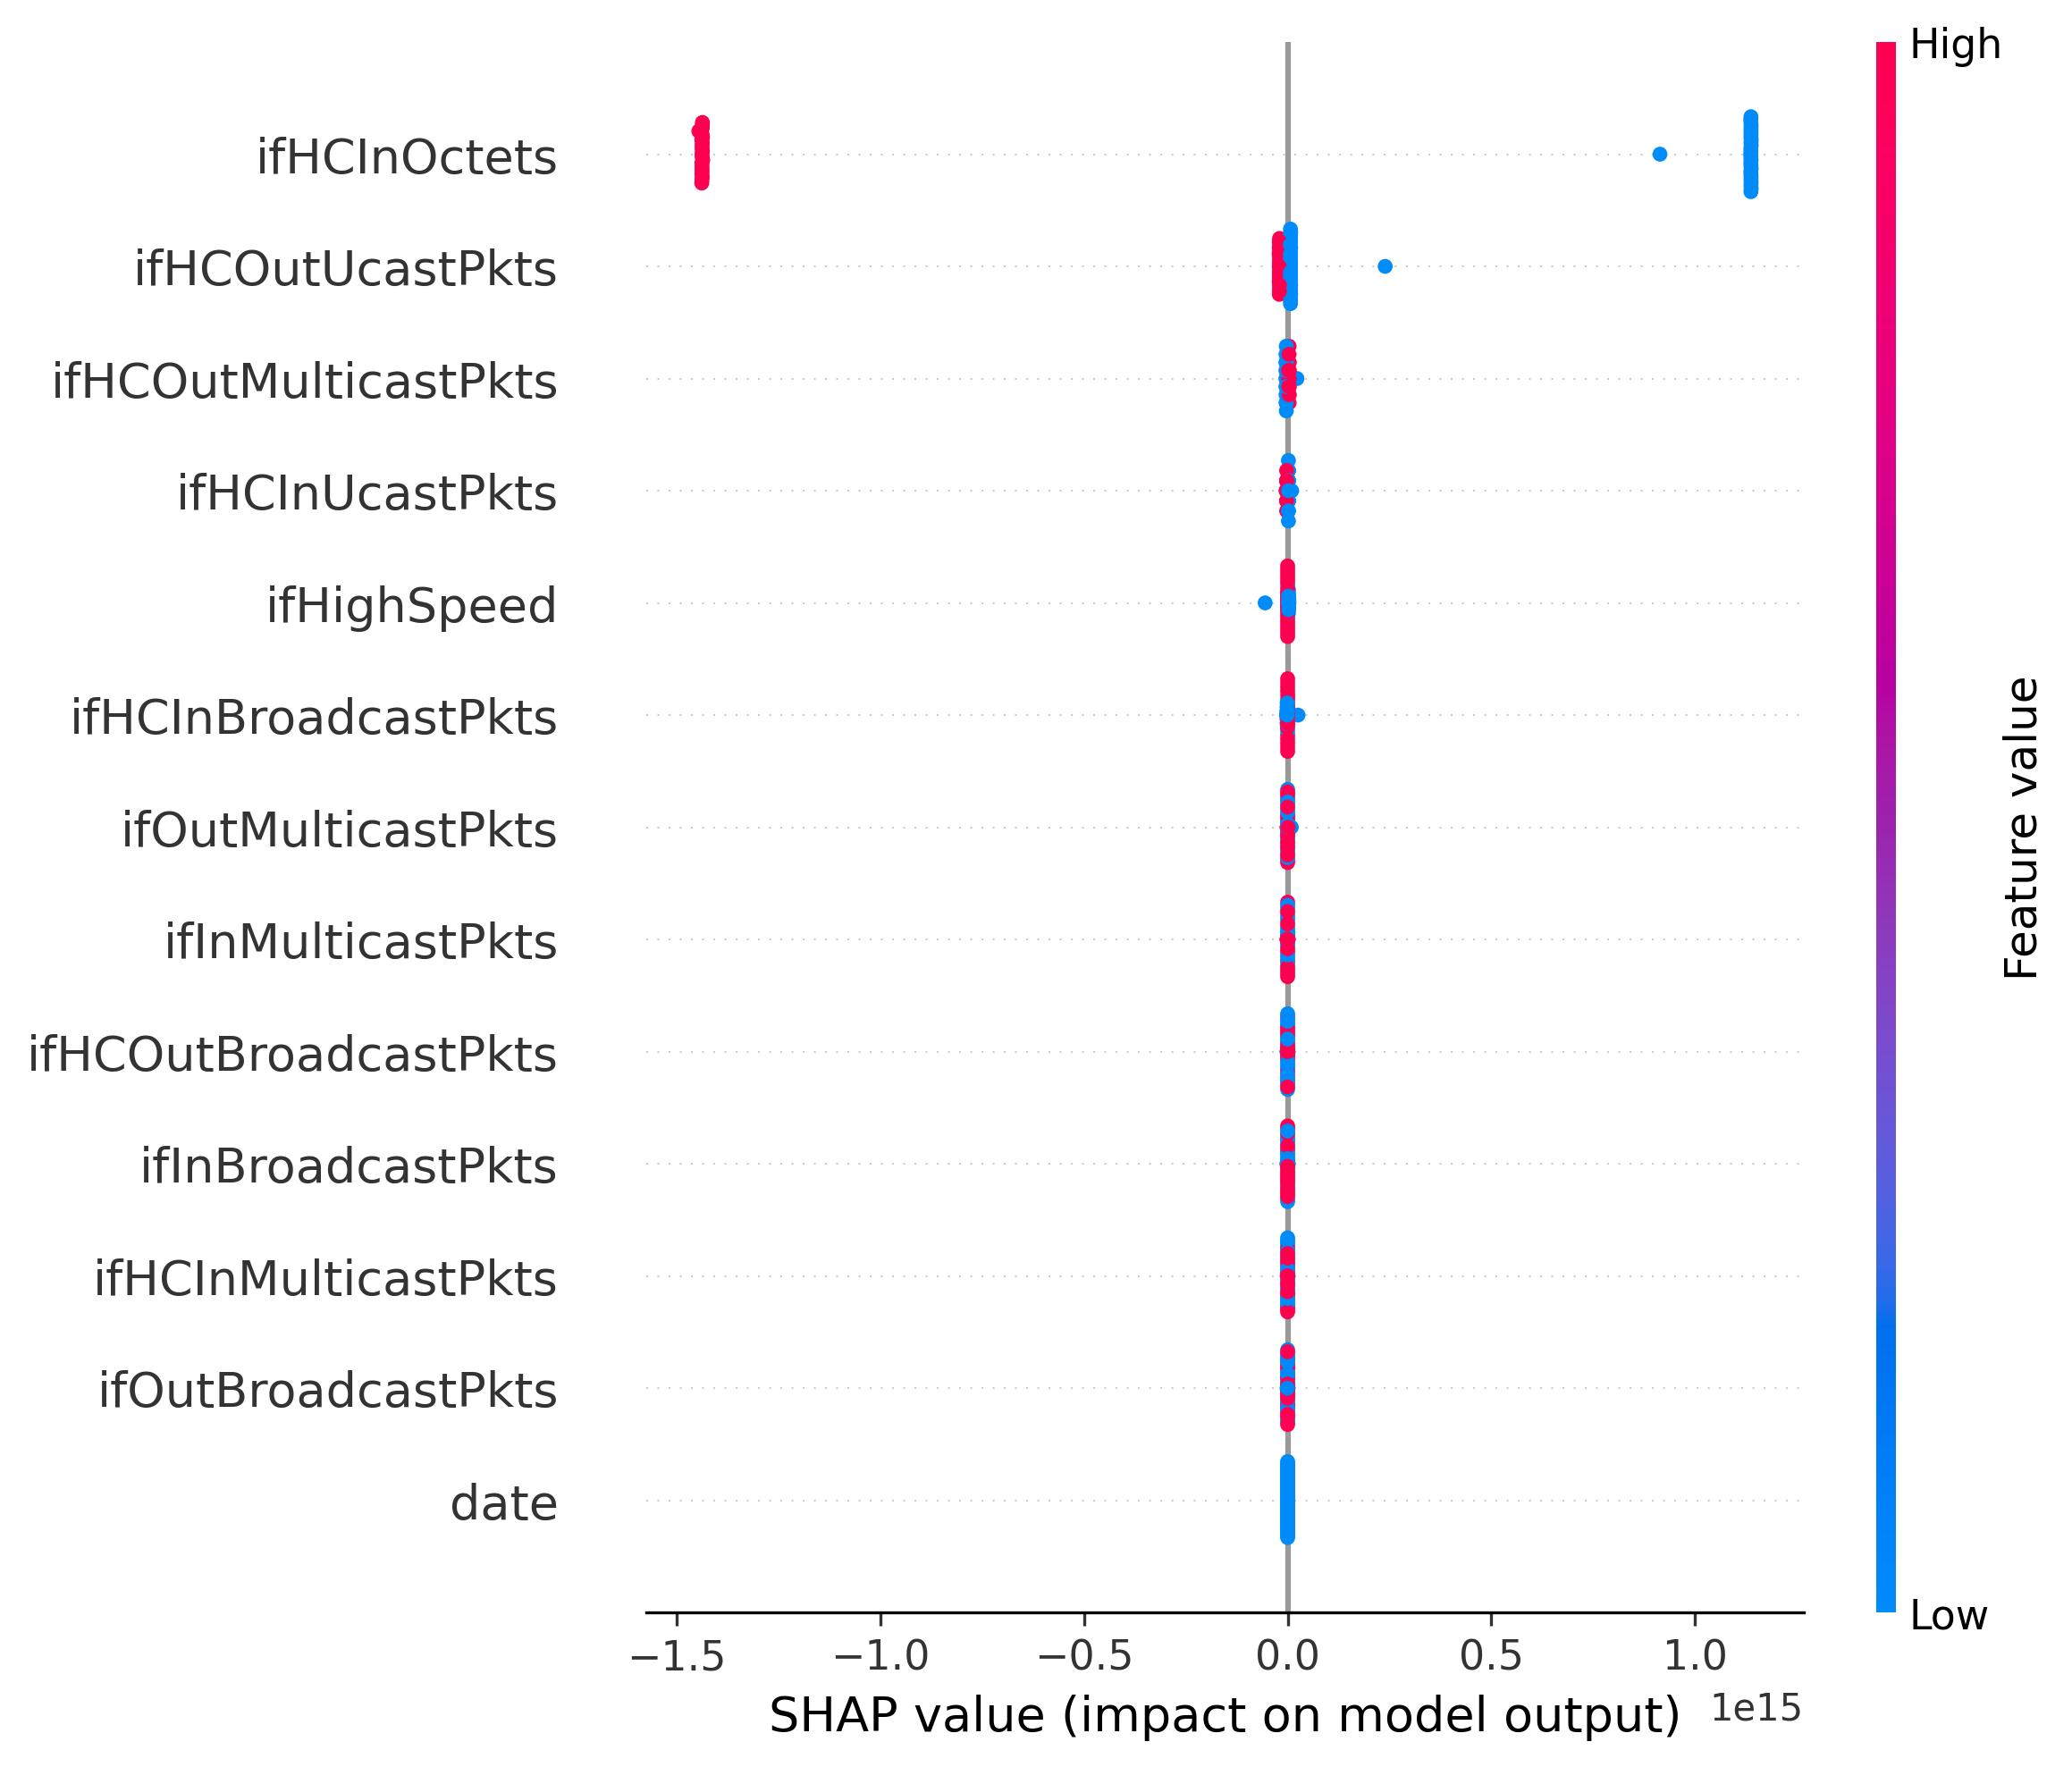

In [39]:
img = Image.open("output_ESNet_octets_bfill_10m.jpg")
print("Shap Summary plot for PatchTST on ifHCOutOctets")
display(img)

In [40]:
df = pd.read_csv("router_metrics_timeseries.csv")

In [41]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df1 = df[df['timestamp'].dt.month == 9]
df2 = df[df['timestamp'].dt.month == 2]

In [42]:
df1 = df1.rename(columns={'timestamp': 'date'})
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d %H:%M:%S')
df1 = df1.set_index('date')
df1 = df1.groupby(df1.index).sum().select_dtypes(include=['number', 'datetime'])
df1 = df1.asfreq('10min', method="bfill")
df1 = df1.sort_index()

In [43]:
df2 = df2.rename(columns={'timestamp': 'date'})
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d %H:%M:%S')
df2 = df2.set_index('date')
df2 = df2.groupby(df2.index).sum().select_dtypes(include=['number', 'datetime'])
df2 = df2.asfreq('10min', method="bfill")
df2 = df2.sort_index()

In [44]:
def fillgap(firstTS, secondTS, seasonal_periods = 6 * 24):
    
    #PREPARATION
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    from datetime import timedelta

    one = timedelta(minutes=10)
    secondTSr = secondTS[::-1].copy()
    firstTSr = firstTS[::-1].copy()

    indexr = pd.date_range(start=firstTS.index[0], end=secondTS.index[-1], freq='10min')
    firstTSr.index = indexr[-len(firstTSr):]
    secondTSr.index = indexr[:len(secondTSr)]
    
    #FORWARD    
    es = ExponentialSmoothing(firstTS,  seasonal_periods=seasonal_periods,seasonal='add').fit()
    forwardPrediction = es.predict(start=firstTS.index[-1]+one, end=secondTS.index[0]-one)
    
    #BACKWARD
    es = ExponentialSmoothing(secondTSr,  seasonal_periods=seasonal_periods,seasonal='add').fit()
    backwardPrediction = es.predict(start=secondTSr.index[-1]+one, end=firstTSr.index[0]-one)
    
    #INTERPOLATION
    forwardPrediction = forwardPrediction[:-1]
    l = len(forwardPrediction)

    interpolation = pd.Series([(backwardPrediction[i] * i + forwardPrediction[i] * (l -i) )/ l for i in range(l)], index=forwardPrediction.index.copy())
  
    return interpolation

In [45]:
df = df.rename(columns={'timestamp': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('date')
df = df.groupby(df.index).sum().select_dtypes(include=['number', 'datetime'])
df = df.asfreq('10min', method="bfill")
df = df.sort_index()
for col in df.columns:
    df[col] = pd.concat([df1[col], fillgap(df1[col], df2[col]), df.loc[df.index.month == 2][col]])
df = df.fillna(method="bfill")
df.to_csv("router_metrics_timeseries_patchtst_expsmooth.csv")

/opt/homebrew/anaconda3/envs/Tachyon/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: divide by zero encountered in matmul
  return err.T @ err
/opt/homebrew/anaconda3/envs/Tachyon/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/homebrew/anaconda3/envs/Tachyon/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: invalid value encountered in matmul
  return err.T @ err
/opt/homebrew/anaconda3/envs/Tachyon/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/envs/Tachyon/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:1409: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/opt/homebrew/anaconda3/envs/Tachyon/lib/python3.13/site-packages/statsmodels/tsa/hol

Train dates : 2024-09-01 00:10:07 --- 2025-01-15 19:10:07  (n=19699)
Test dates  : 2025-01-15 19:20:07 --- 2025-02-18 06:20:07  (n=4819)


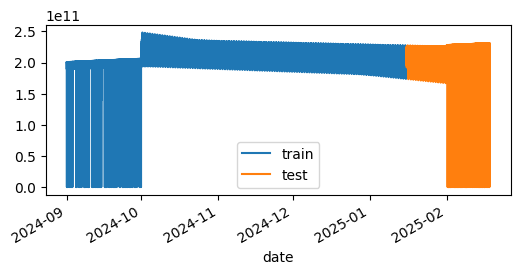

In [46]:
# Split data into train-test
# ==============================================================================
data  = df

steps = 4819
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['ifHCOutBroadcastPkts'].plot(ax=ax, label='train')
data_test['ifHCOutBroadcastPkts'].plot(ax=ax, label='test')
ax.legend();

In [47]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 1
             )
forecaster.fit(y=data_train['ifHCOutBroadcastPkts'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1] 
Window features: None 
Window size: 1 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2024-09-01 00:10:07'), Timestamp('2025-01-15 19:10:07')] 
Training index type: DatetimeIndex 
Training index frequency: 10min 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-21 10:36:54 
Last fit date: 2025-05-21 10:36:56 
Skforecast version: 0.14.0 
Python version: 3.13.1 
Forecaster id: None

In [48]:
# Predictions
# ==============================================================================
steps = 4819
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2025-01-15 19:20:07    2.022166e+11
2025-01-15 19:30:07    2.021777e+11
2025-01-15 19:40:07    1.987472e+11
2025-01-15 19:50:07    2.184183e+11
2025-01-15 20:00:07    2.183600e+11
Freq: 10min, Name: pred, dtype: float64

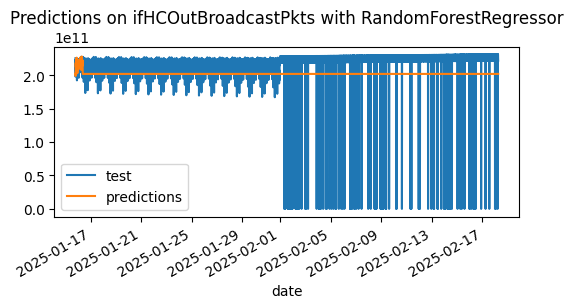

In [49]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_test['ifHCOutBroadcastPkts'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.set_title("Predictions on ifHCOutBroadcastPkts with RandomForestRegressor")
ax.legend();

Shap Summary plot for Random Forest Regressor on ifHCOutBroadcastPkts


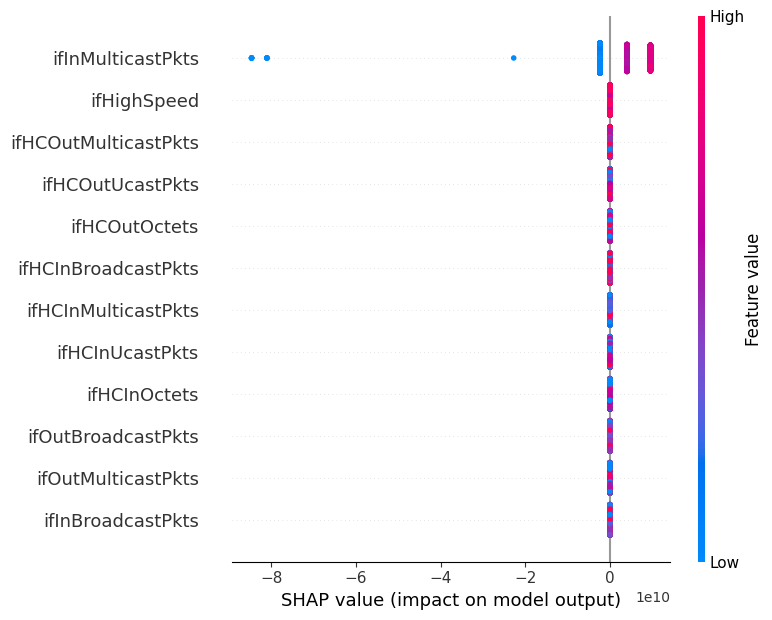

In [50]:
X_train = data_train.copy(deep=True)
X_train.pop("ifHCOutBroadcastPkts")
X_test = data_test.copy(deep=True)
X_test.pop("ifHCOutBroadcastPkts")
print("Shap Summary plot for Random Forest Regressor on ifHCOutBroadcastPkts")
explainer = shap.TreeExplainer(forecaster.regressor, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [51]:
# 1) fit
scaler = StandardScaler().fit(data_test['ifHCOutBroadcastPkts'].to_numpy().reshape(-1, 1))

# 2) transform
y_true_s = scaler.transform(data_test['ifHCOutBroadcastPkts'].to_numpy().reshape(-1, 1)).reshape(data_test['ifHCOutBroadcastPkts'].shape)
y_pred_s = scaler.transform(predictions.to_numpy().reshape(-1, 1)).reshape(predictions.shape)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_true_s,
                y_pred = y_pred_s
            )
error_smape = smape(y_true_s, y_pred_s)
print(f"Test error (MSE): {error_mse}")
print(f"Test error (SMAPE): {error_smape}")

Test error (MSE): 1.156088757931344
Test error (SMAPE): 168.57201637956857


In [52]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 1
             )
forecaster.fit(y=data_train['ifHCOutOctets'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1] 
Window features: None 
Window size: 1 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2024-09-01 00:10:07'), Timestamp('2025-01-15 19:10:07')] 
Training index type: DatetimeIndex 
Training index frequency: 10min 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-21 10:37:08 
Last fit date: 2025-05-21 10:37:09 
Skforecast version: 0.14.0 
Python version: 3.13.1 
Forecaster id: None

In [53]:
# Predictions
# ==============================================================================
steps = 4819
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2025-01-15 19:20:07    7.243808e+16
2025-01-15 19:30:07    6.119137e+16
2025-01-15 19:40:07    7.245080e+16
2025-01-15 19:50:07    5.910221e+16
2025-01-15 20:00:07    6.732612e+16
Freq: 10min, Name: pred, dtype: float64

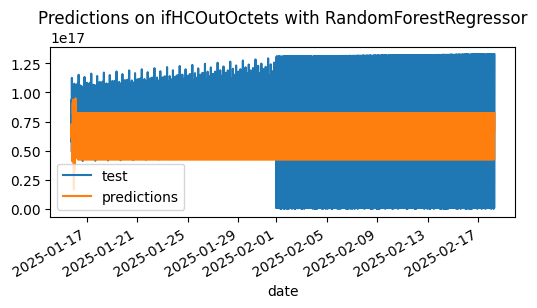

In [54]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_test['ifHCOutOctets'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.set_title("Predictions on ifHCOutOctets with RandomForestRegressor")
ax.legend();

In [55]:
# 1) fit
scaler = StandardScaler().fit(data_test['ifHCOutOctets'].to_numpy().reshape(-1, 1))

# 2) transform
y_true_s = scaler.transform(data_test['ifHCOutOctets'].to_numpy().reshape(-1, 1)).reshape(data_test['ifHCOutOctets'].shape)
y_pred_s = scaler.transform(predictions.to_numpy().reshape(-1, 1)).reshape(predictions.shape)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_true_s,
                y_pred = y_pred_s
            )
error_smape = smape(y_true_s, y_pred_s)
print(f"Test error (MSE): {error_mse}")
print(f"Test error (SMAPE): {error_smape}")

Test error (MSE): 1.0827455370134649
Test error (SMAPE): 153.9428327920067


Shap Summary plot for Random Forest Regressor on ifHCOutOctets


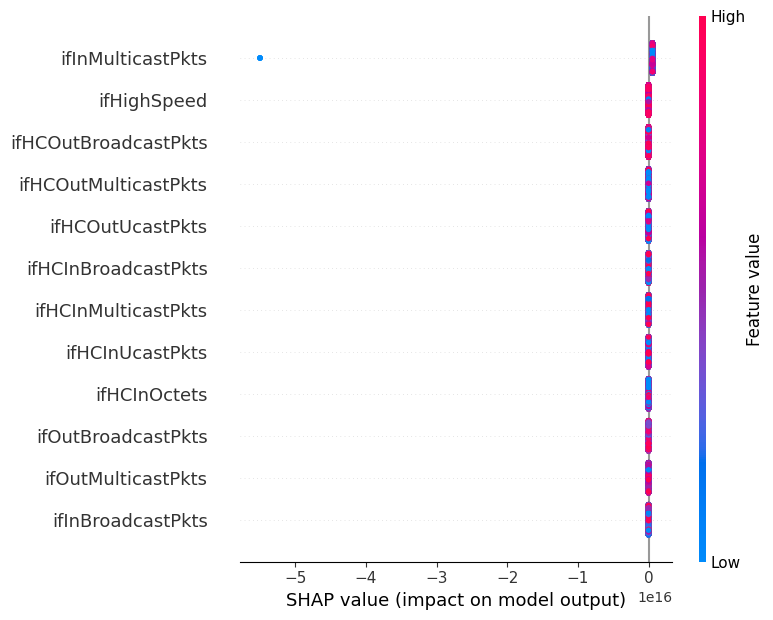

In [56]:
X_train = data_train.copy(deep=True)
X_train.pop("ifHCOutOctets")
X_test = data_test.copy(deep=True)
X_test.pop("ifHCOutOctets")
print("Shap Summary plot for Random Forest Regressor on ifHCOutOctets")
explainer = shap.TreeExplainer(forecaster.regressor, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [57]:
df = pd.read_csv("router_metrics_quantum_annealing.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index("date")
df = df.asfreq('10min')

Train dates : 2024-09-01 00:10:07 --- 2025-01-15 19:10:07  (n=19699)
Test dates  : 2025-01-15 19:20:07 --- 2025-02-18 06:20:07  (n=4819)


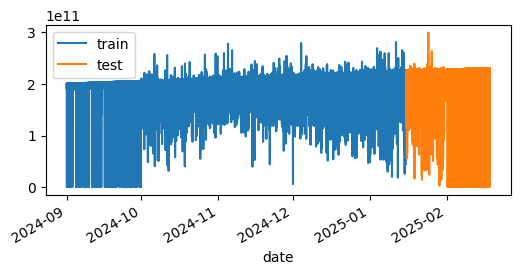

In [58]:
# Split data into train-test
# ==============================================================================
data  = df

steps = 4819
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['ifHCOutBroadcastPkts'].plot(ax=ax, label='train')
data_test['ifHCOutBroadcastPkts'].plot(ax=ax, label='test')
ax.legend();

In [59]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 1
             )
forecaster.fit(y=data_train['ifHCOutBroadcastPkts'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1] 
Window features: None 
Window size: 1 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2024-09-01 00:10:07'), Timestamp('2025-01-15 19:10:07')] 
Training index type: DatetimeIndex 
Training index frequency: 10min 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-21 10:37:26 
Last fit date: 2025-05-21 10:37:28 
Skforecast version: 0.14.0 
Python version: 3.13.1 
Forecaster id: None

In [60]:
# Predictions
# ==============================================================================
steps = 4819
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2025-01-15 19:20:07    2.211906e+11
2025-01-15 19:30:07    2.086105e+11
2025-01-15 19:40:07    1.852529e+11
2025-01-15 19:50:07    2.065255e+11
2025-01-15 20:00:07    1.967355e+11
Freq: 10min, Name: pred, dtype: float64

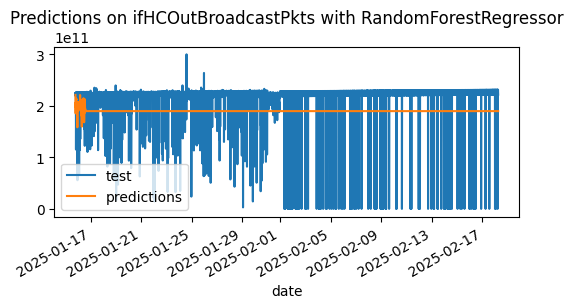

In [61]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_test['ifHCOutBroadcastPkts'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.set_title("Predictions on ifHCOutBroadcastPkts with RandomForestRegressor")
ax.legend();

Shap Summary plot for Random Forest Regressor on ifHCOutBroadcastPkts


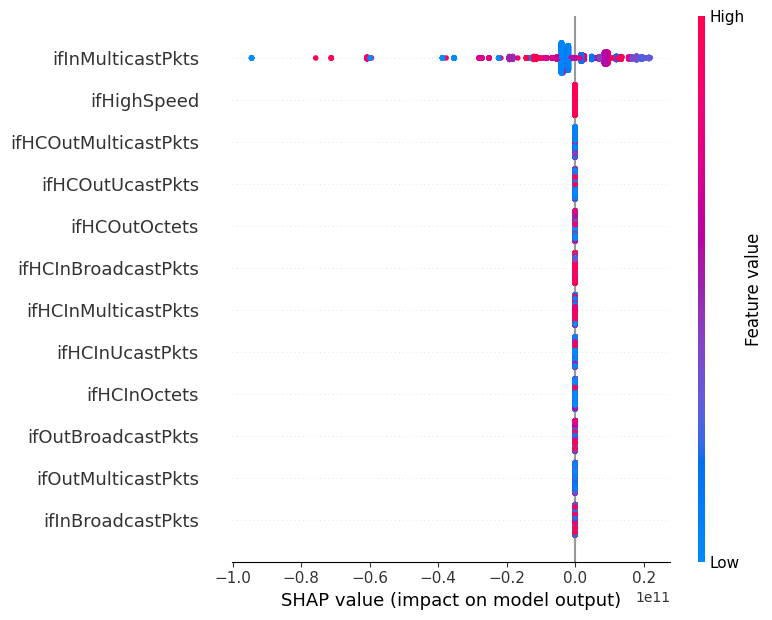

In [62]:
X_train = data_train.copy(deep=True)
X_train.pop("ifHCOutBroadcastPkts")
X_test = data_test.copy(deep=True)
X_test.pop("ifHCOutBroadcastPkts")
print("Shap Summary plot for Random Forest Regressor on ifHCOutBroadcastPkts")
explainer = shap.TreeExplainer(forecaster.regressor, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [63]:
# 1) fit
scaler = StandardScaler().fit(data_test['ifHCOutBroadcastPkts'].to_numpy().reshape(-1, 1))

# 2) transform
y_true_s = scaler.transform(data_test['ifHCOutBroadcastPkts'].to_numpy().reshape(-1, 1)).reshape(data_test['ifHCOutBroadcastPkts'].shape)
y_pred_s = scaler.transform(predictions.to_numpy().reshape(-1, 1)).reshape(predictions.shape)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_true_s,
                y_pred = y_pred_s
            )
error_smape = smape(y_true_s, y_pred_s)
print(f"Test error (MSE): {error_mse}")
print(f"Test error (SMAPE): {error_smape}")

Test error (MSE): 1.434058237724906
Test error (SMAPE): 191.42444751009862


In [64]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 1
             )
forecaster.fit(y=data_train['ifHCOutOctets'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1] 
Window features: None 
Window size: 1 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2024-09-01 00:10:07'), Timestamp('2025-01-15 19:10:07')] 
Training index type: DatetimeIndex 
Training index frequency: 10min 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-21 10:37:44 
Last fit date: 2025-05-21 10:37:46 
Skforecast version: 0.14.0 
Python version: 3.13.1 
Forecaster id: None

In [65]:
# Predictions
# ==============================================================================
steps = 4819
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2025-01-15 19:20:07    3.597188e+16
2025-01-15 19:30:07    6.555908e+16
2025-01-15 19:40:07    4.988115e+16
2025-01-15 19:50:07    5.061621e+16
2025-01-15 20:00:07    5.410186e+16
Freq: 10min, Name: pred, dtype: float64

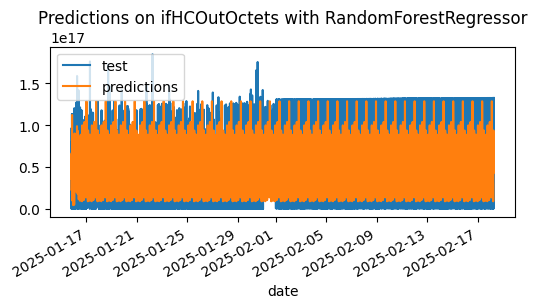

In [66]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_test['ifHCOutOctets'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.set_title("Predictions on ifHCOutOctets with RandomForestRegressor")
ax.legend();

In [67]:
# 1) fit
scaler = StandardScaler().fit(data_test['ifHCOutOctets'].to_numpy().reshape(-1, 1))

# 2) transform
y_true_s = scaler.transform(data_test['ifHCOutOctets'].to_numpy().reshape(-1, 1)).reshape(data_test['ifHCOutOctets'].shape)
y_pred_s = scaler.transform(predictions.to_numpy().reshape(-1, 1)).reshape(predictions.shape)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_true_s,
                y_pred = y_pred_s
            )
error_smape = smape(y_true_s, y_pred_s)
print(f"Test error (MSE): {error_mse}")
print(f"Test error (SMAPE): {error_smape}")

Test error (MSE): 1.2364745782144722
Test error (SMAPE): 155.9369846362111


In [68]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell: SAITS Imputation with Standardization + Inverse Transform
# ─────────────────────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pypots.imputation.saits import SAITS

# 1) Snap & align df1, df2 onto a uniform 10-minute grid, exactly as before:
step = df1.index[1] - df1.index[0]
start = df1.index.min()

def snap_to_grid(idx):
    rel = ((idx - start) / step).round().astype(int)
    return start + rel * step

df1_snap = df1.copy()
df1_snap.index = snap_to_grid(df1_snap.index)
df1_snap = df1_snap[~df1_snap.index.duplicated()]

df2_snap = df2.copy()
df2_snap.index = snap_to_grid(df2_snap.index)
df2_snap = df2_snap[~df2_snap.index.duplicated()]

gap_start = df1_snap.index.max() + step
gap_end   = df2_snap.index.min() - step
gap_idx   = pd.date_range(gap_start, gap_end, freq=step)

full_index = df1_snap.index.union(gap_idx).union(df2_snap.index).sort_values()
full = pd.DataFrame(index=full_index, columns=df1.columns, dtype=float)
full.loc[df1_snap.index] = df1_snap
full.loc[df2_snap.index] = df2_snap

# 2) Standardize each feature on known data
full_vals = full.values  # shape (T, F), with NaNs in the gap
scaler = StandardScaler()

# fit only on the non-NaN rows
mask_known = ~np.isnan(full_vals).any(axis=1)
scaler.fit(full_vals[mask_known])

# transform entire series (gap rows remain NaN)
full_scaled = scaler.transform(full_vals)

# 3) Mask the gap in the scaled space
mask_scaled = full_scaled.copy()
gap_pos = [full_index.get_loc(ts) for ts in gap_idx]
mask_scaled[gap_pos, :] = np.nan

# 4) Prepare PyPOTS inputs
X_ori    = full_scaled[np.newaxis, ...]     # (1, T, F)
X_masked = mask_scaled[np.newaxis, ...]
train_set = {"X": X_masked}
val_set   = {"X": X_masked, "X_ori": X_ori}

# 5) Train SAITS on the ONE scaled sequence
n_steps, n_features = full_scaled.shape
saits = SAITS(
    n_steps=n_steps, n_features=n_features,
    n_layers=2, d_model=64,
    n_heads=4, d_k=16, d_v=16,
    d_ffn=128, epochs=100,    # ↑ bump epochs if needed
)
saits.fit(train_set, val_set)

# 6) Impute (still in scaled space)
imputed_scaled = saits.impute(train_set)[0]   # (T, F)

# 7) Inverse‐transform back to original units
imputed = scaler.inverse_transform(imputed_scaled)

# 8) Stitch back only the gap rows
df_imp = pd.DataFrame(imputed, index=full_index, columns=full.columns)
output = full.copy()
output.loc[gap_idx, :] = df_imp.loc[gap_idx, :]

# 9) Save your final series
output.to_csv("router_metrics_saits_standardized.csv")

2025-05-21 10:37:58 [INFO]: No given device, using default device: cpu
2025-05-21 10:37:58 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-05-21 10:37:58 [INFO]: Using customized MAE as the training loss function.
2025-05-21 10:37:58 [INFO]: Using customized MSE as the validation metric function.
2025-05-21 10:37:58 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 457,108



████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



2025-05-21 10:39:14 [INFO]: Epoch 001 - training loss (MAE): 1.7876, validation MSE: 0.0000
2025-05-21 10:40:22 [INFO]: Epoch 002 - training loss (MAE): 1.6905, validation MSE: 0.0000
2025-05-21 10:41:26 [INFO]: Epoch 003 - training loss (MAE): 1.6206, validation MSE: 0.0000
2025-05-21 10:42:29 [INFO]: Epoch 004 - training loss (MAE): 1.5515, validation MSE: 0.0000
2025-05-21 10:43:33 [INFO]: Epoch 005 - training loss (MAE): 1.4834, validation MSE: 0.0000
2025-05-21 10:44:36 [INFO]: Epoch 006 - training loss (MAE): 1.4243, validation MSE: 0.0000
2025-05-21 10:45:43 [INFO]: Epoch 007 - training loss (MAE): 1.3515, validation MSE: 0.0000
2025-05-21 10:46:45 [INFO]: Epoch 008 - training loss (MAE): 1.2831, validation MSE: 0.0000
2025-05-21 10:47:50 [INFO]: Epoch 009 - training loss (MAE): 1.2120, validation MSE: 0.0000
2025-05-21 10:48:53 [INFO]: Epoch 010 - training loss (MAE): 1.1465, validation MSE: 0.0000
2025-05-21 10:49:58 [INFO]: Epoch 011 - training loss (MAE): 1.0884, validation 

In [69]:
df = output

Train dates : 2024-09-01 00:10:07 --- 2025-01-15 19:10:07  (n=19699)
Test dates  : 2025-01-15 19:20:07 --- 2025-02-18 06:20:07  (n=4819)


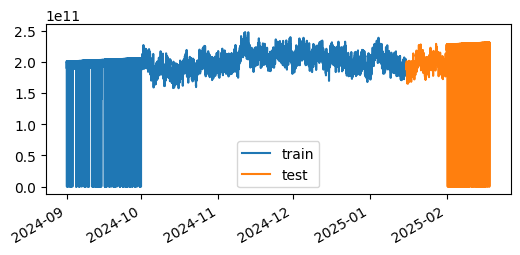

In [70]:
# Split data into train-test
# ==============================================================================
data  = df

steps = 4819
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['ifHCOutBroadcastPkts'].plot(ax=ax, label='train')
data_test['ifHCOutBroadcastPkts'].plot(ax=ax, label='test')
ax.legend();

In [71]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 1
             )
forecaster.fit(y=data_train['ifHCOutBroadcastPkts'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1] 
Window features: None 
Window size: 1 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2024-09-01 00:10:07'), Timestamp('2025-01-15 19:10:07')] 
Training index type: DatetimeIndex 
Training index frequency: 10min 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-21 10:51:17 
Last fit date: 2025-05-21 10:51:19 
Skforecast version: 0.14.0 
Python version: 3.13.1 
Forecaster id: None

In [72]:
# Predictions
# ==============================================================================
steps = 4819
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2025-01-15 19:20:07    1.861750e+11
2025-01-15 19:30:07    1.886381e+11
2025-01-15 19:40:07    1.864272e+11
2025-01-15 19:50:07    1.877964e+11
2025-01-15 20:00:07    1.914069e+11
Freq: 10min, Name: pred, dtype: float64

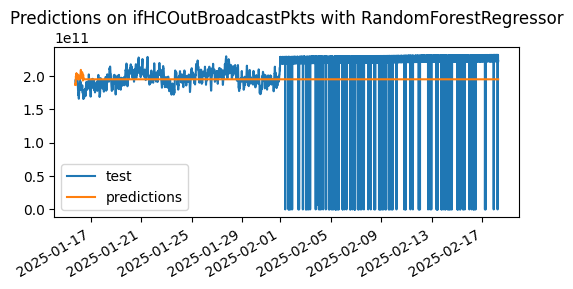

In [73]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_test['ifHCOutBroadcastPkts'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.set_title("Predictions on ifHCOutBroadcastPkts with RandomForestRegressor")
ax.legend();

Shap Summary plot for Random Forest Regressor on ifHCOutBroadcastPkts


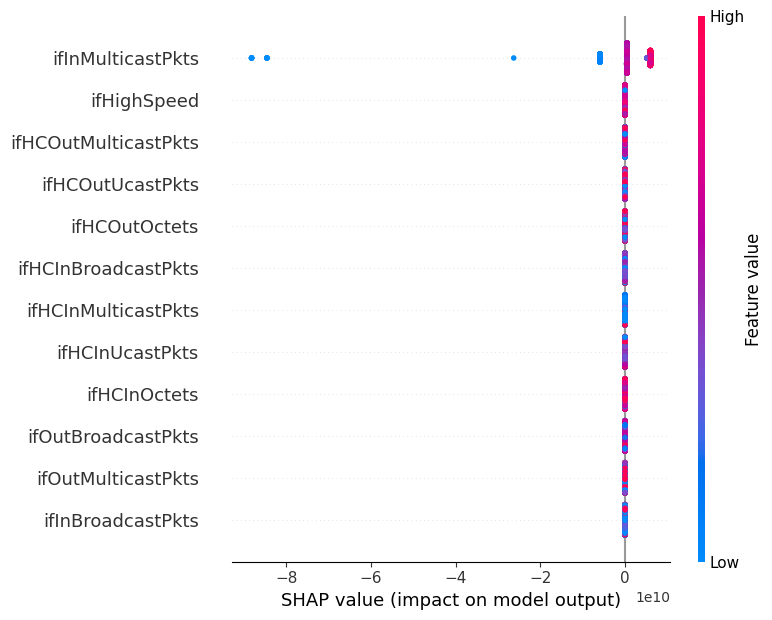

In [74]:
X_train = data_train.copy(deep=True)
X_train.pop("ifHCOutBroadcastPkts")
X_test = data_test.copy(deep=True)
X_test.pop("ifHCOutBroadcastPkts")
print("Shap Summary plot for Random Forest Regressor on ifHCOutBroadcastPkts")
explainer = shap.TreeExplainer(forecaster.regressor, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [75]:
# 1) fit
scaler = StandardScaler().fit(data_test['ifHCOutBroadcastPkts'].to_numpy().reshape(-1, 1))

# 2) transform
y_true_s = scaler.transform(data_test['ifHCOutBroadcastPkts'].to_numpy().reshape(-1, 1)).reshape(data_test['ifHCOutBroadcastPkts'].shape)
y_pred_s = scaler.transform(predictions.to_numpy().reshape(-1, 1)).reshape(predictions.shape)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_true_s,
                y_pred = y_pred_s
            )
error_smape = smape(y_true_s, y_pred_s)
print(f"Test error (MSE): {error_mse}")
print(f"Test error (SMAPE): {error_smape}")

Test error (MSE): 1.0806139023029395
Test error (SMAPE): 146.72598208198755


In [76]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 1
             )
forecaster.fit(y=data_train['ifHCOutOctets'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1] 
Window features: None 
Window size: 1 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2024-09-01 00:10:07'), Timestamp('2025-01-15 19:10:07')] 
Training index type: DatetimeIndex 
Training index frequency: 10min 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-21 10:51:32 
Last fit date: 2025-05-21 10:51:33 
Skforecast version: 0.14.0 
Python version: 3.13.1 
Forecaster id: None

In [77]:
# Predictions
# ==============================================================================
steps = 4819
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2025-01-15 19:20:07    6.058948e+16
2025-01-15 19:30:07    6.673667e+16
2025-01-15 19:40:07    6.927964e+16
2025-01-15 19:50:07    7.906137e+16
2025-01-15 20:00:07    8.081424e+16
Freq: 10min, Name: pred, dtype: float64

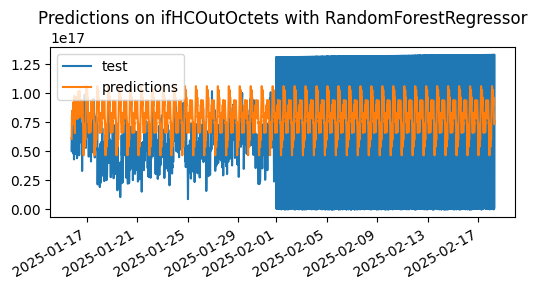

In [78]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_test['ifHCOutOctets'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.set_title("Predictions on ifHCOutOctets with RandomForestRegressor")
ax.legend();

In [79]:
# 1) fit
scaler = StandardScaler().fit(data_test['ifHCOutOctets'].to_numpy().reshape(-1, 1))

# 2) transform
y_true_s = scaler.transform(data_test['ifHCOutOctets'].to_numpy().reshape(-1, 1)).reshape(data_test['ifHCOutOctets'].shape)
y_pred_s = scaler.transform(predictions.to_numpy().reshape(-1, 1)).reshape(predictions.shape)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_true_s,
                y_pred = y_pred_s
            )
error_smape = smape(y_true_s, y_pred_s)
print(f"Test error (MSE): {error_mse}")
print(f"Test error (SMAPE): {error_smape}")

Test error (MSE): 1.0814336226247927
Test error (SMAPE): 165.55820848109312


In [80]:
# 1) Install dependencies
!pip install pypots scikit-learn tqdm

# 2) Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pypots.imputation.brits import BRITS

# 3) Snap df1 and df2 to a regular 10-minute time grid
step  = df1.index[1] - df1.index[0]
start = df1.index.min()

def snap(idx):
    rel = ((idx - start) / step).round().astype(int)
    return start + rel * step

df1.index = snap(df1.index)
df2.index = snap(df2.index)
df1 = df1[~df1.index.duplicated()]
df2 = df2[~df2.index.duplicated()]

# 4) Construct full time index covering df1, the gap, and df2
gap_start = df1.index.max() + step
gap_end   = df2.index.min() - step
gap_idx   = pd.date_range(start=gap_start, end=gap_end, freq=step)
full_index = df1.index.union(gap_idx).union(df2.index).sort_values()

# 5) Initialize full DataFrame with NaNs and insert known values
full = pd.DataFrame(index=full_index, columns=df1.columns, dtype=float)
full.loc[df1.index] = df1
full.loc[df2.index] = df2

# 6) Standardize known values
vals = full.values
known_mask = ~np.isnan(vals).any(axis=1)
scaler = StandardScaler().fit(vals[known_mask])
full_scaled = scaler.transform(vals)  # gap remains NaN

# 7) Prepare BRITS input
X = full_scaled[np.newaxis, ...]  # shape (1, T, F)

# 8) Define train/val sets using same input (unsupervised)
train_set = {"X": X}
val_set = {"X": X, "X_ori": X.copy()}

# 9) Train BRITS directly on the large-gap time series
T, F = full_scaled.shape
brits = BRITS(
    n_steps=T,
    n_features=F,
    rnn_hidden_size=128,
    batch_size=1,
    epochs=100,
)
brits.fit(train_set, val_set)

# 10) Impute the full sequence (including the gap)
imputed = brits.impute({"X": X})[0]

# 11) Inverse-transform and restore time index
filled = scaler.inverse_transform(imputed)
output = pd.DataFrame(filled, index=full_index, columns=full.columns)

# 12) Save or return
output.to_csv("router_metrics_brits_fullgap.csv")

/opt/homebrew/anaconda3/envs/Tachyon/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=2008) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


2025-05-21 10:51:43 [INFO]: No given device, using default device: cpu
2025-05-21 10:51:43 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-05-21 10:51:43 [INFO]: Using customized MAE as the training loss function.
2025-05-21 10:51:43 [INFO]: Using customized MSE as the validation metric function.
2025-05-21 10:51:43 [INFO]: BRITS initialized with the given hyperparameters, the number of trainable parameters: 168,112
2025-05-21 10:52:07 [INFO]: Epoch 001 - training loss (MAE): 0.5125, validation MSE: 0.0000
2025-05-21 10:52:30 [INFO]: Epoch 002 - training loss (MAE): 0.5065, validation MSE: 0.0000
2025-05-21 10:52:52 [INFO]: Epoch 003 - training loss (MAE): 0.5004, validation MSE: 0.0000
2025-05-21 10:53:15 [INFO]: Epoch 004 - training loss (MAE): 0.4942, validation MSE: 0.0000
2025-05-21 10:53:38 [INFO]: Epoch 005 - training loss (MAE): 0.4886, validation MSE: 0.0000
2025-05-21 10:54:01 [INFO]: Epoch 006 - training loss (MAE): 0.4843, valid

Train dates : 2024-09-01 00:10:07 --- 2025-01-15 19:10:07  (n=19699)
Test dates  : 2025-01-15 19:20:07 --- 2025-02-18 06:20:07  (n=4819)


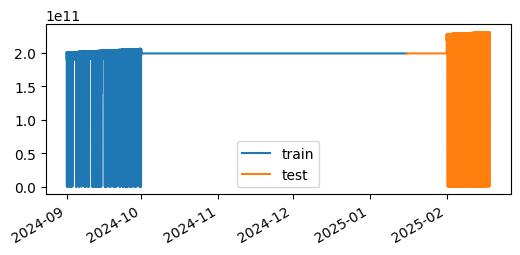

In [81]:
df = output

# Split data into train-test
# ==============================================================================
data  = df

steps = 4819
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['ifHCOutBroadcastPkts'].plot(ax=ax, label='train')
data_test['ifHCOutBroadcastPkts'].plot(ax=ax, label='test')
ax.legend();

In [83]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 1
             )
forecaster.fit(y=data_train['ifHCOutBroadcastPkts'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1] 
Window features: None 
Window size: 1 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2024-09-01 00:10:07'), Timestamp('2025-01-15 19:10:07')] 
Training index type: DatetimeIndex 
Training index frequency: 10min 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-21 12:01:45 
Last fit date: 2025-05-21 12:01:46 
Skforecast version: 0.14.0 
Python version: 3.13.1 
Forecaster id: None

In [84]:
# Predictions
# ==============================================================================
steps = 4819
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2025-01-15 19:20:07    1.992057e+11
2025-01-15 19:30:07    1.992057e+11
2025-01-15 19:40:07    1.992057e+11
2025-01-15 19:50:07    1.992057e+11
2025-01-15 20:00:07    1.992057e+11
Freq: 10min, Name: pred, dtype: float64

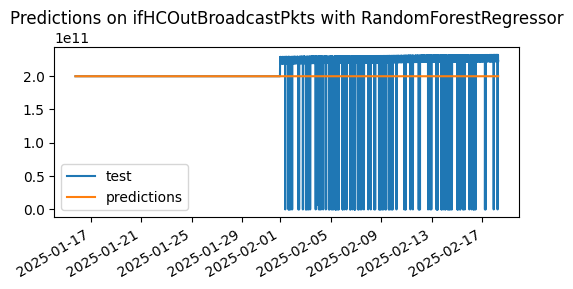

In [85]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_test['ifHCOutBroadcastPkts'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.set_title("Predictions on ifHCOutBroadcastPkts with RandomForestRegressor")
ax.legend();

Shap Summary plot for Random Forest Regressor on ifHCOutBroadcastPkts


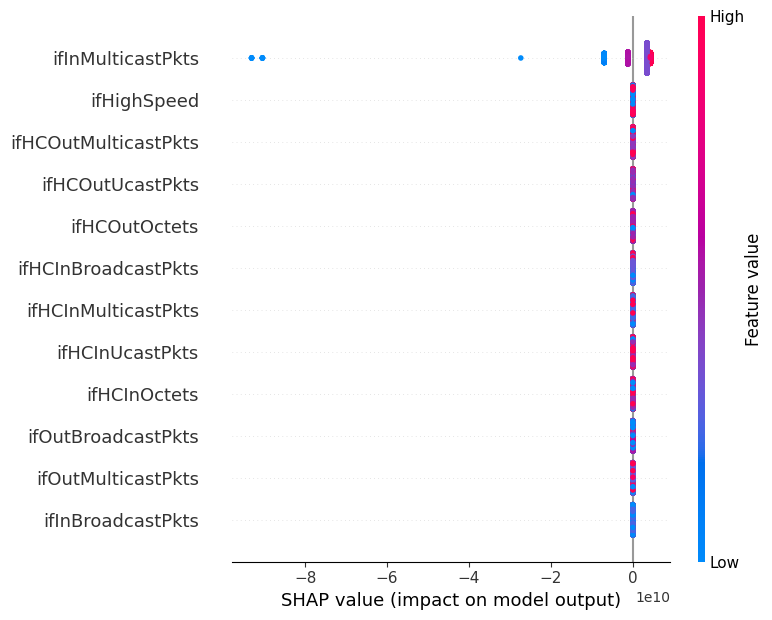

In [86]:
X_train = data_train.copy(deep=True)
X_train.pop("ifHCOutBroadcastPkts")
X_test = data_test.copy(deep=True)
X_test.pop("ifHCOutBroadcastPkts")
print("Shap Summary plot for Random Forest Regressor on ifHCOutBroadcastPkts")
explainer = shap.TreeExplainer(forecaster.regressor, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [87]:
# 1) fit
scaler = StandardScaler().fit(data_test['ifHCOutBroadcastPkts'].to_numpy().reshape(-1, 1))

# 2) transform
y_true_s = scaler.transform(data_test['ifHCOutBroadcastPkts'].to_numpy().reshape(-1, 1)).reshape(data_test['ifHCOutBroadcastPkts'].shape)
y_pred_s = scaler.transform(predictions.to_numpy().reshape(-1, 1)).reshape(predictions.shape)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_true_s,
                y_pred = y_pred_s
            )
error_smape = smape(y_true_s, y_pred_s)
print(f"Test error (MSE): {error_mse}")
print(f"Test error (SMAPE): {error_smape}")

Test error (MSE): 1.0412857596016734
Test error (SMAPE): 102.96531633282657


In [88]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 1
             )
forecaster.fit(y=data_train['ifHCOutOctets'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1] 
Window features: None 
Window size: 1 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2024-09-01 00:10:07'), Timestamp('2025-01-15 19:10:07')] 
Training index type: DatetimeIndex 
Training index frequency: 10min 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-21 12:06:22 
Last fit date: 2025-05-21 12:06:22 
Skforecast version: 0.14.0 
Python version: 3.13.1 
Forecaster id: None

In [89]:
# Predictions
# ==============================================================================
steps = 4819
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2025-01-15 19:20:07    6.760563e+16
2025-01-15 19:30:07    6.760563e+16
2025-01-15 19:40:07    6.760563e+16
2025-01-15 19:50:07    6.760563e+16
2025-01-15 20:00:07    6.760563e+16
Freq: 10min, Name: pred, dtype: float64

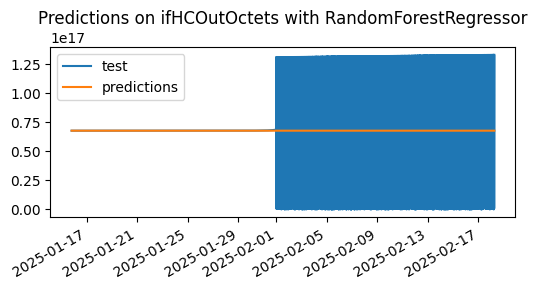

In [90]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_test['ifHCOutOctets'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.set_title("Predictions on ifHCOutOctets with RandomForestRegressor")
ax.legend();

In [91]:
# 1) fit
scaler = StandardScaler().fit(data_test['ifHCOutOctets'].to_numpy().reshape(-1, 1))

# 2) transform
y_true_s = scaler.transform(data_test['ifHCOutOctets'].to_numpy().reshape(-1, 1)).reshape(data_test['ifHCOutOctets'].shape)
y_pred_s = scaler.transform(predictions.to_numpy().reshape(-1, 1)).reshape(predictions.shape)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_true_s,
                y_pred = y_pred_s
            )
error_smape = smape(y_true_s, y_pred_s)
print(f"Test error (MSE): {error_mse}")
print(f"Test error (SMAPE): {error_smape}")

Test error (MSE): 1.0691341147748916
Test error (SMAPE): 94.89942127087609
